In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'freehand_v2.1_double_input_mp_iq'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers import Input, concatenate
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D

from tensorflow.keras.layers import Input

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return [modules, phases]

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","[[0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","[[0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","[[0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","[[0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","[[0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","[[0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","[[0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","[[0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","[[0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
iq_signals = dataset_df[iq_signals_column_dataframe_name].tolist()
mp_signals = dataset_df[module_phase_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(iq_signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

iq_signals = np.array(iq_signals)
mp_signals = np.array(mp_signals)

iq_train = iq_signals[train_index]
iq_test =  iq_signals[test_index]

mp_train = mp_signals[train_index]
mp_test =  mp_signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
iq_shape = iq_train.shape
mp_shape = mp_train.shape
print(iq_shape)
print(mp_shape)
iq_shape = list(iq_shape[1:])
mp_shape = list(mp_shape[1:])

classes = mods

(154000, 2, 128)
(154000, 2, 128)


In [16]:
model = neural_networks.freehand_v2_1_double_input(iq_shape, mp_shape)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2, 128)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2, 128, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 128, 1)    0           input_2[0][0]                    
______________________________________________________________________________________________

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    (iq_train, mp_train),
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=((iq_test, mp_test), Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 35:29 - loss: 2.4007

  2/151 [..............................] - ETA: 17s - loss: 2.3997  

  3/151 [..............................] - ETA: 17s - loss: 2.3990

  4/151 [..............................] - ETA: 17s - loss: 2.3982

  5/151 [..............................] - ETA: 17s - loss: 2.3970

  6/151 [>.............................] - ETA: 17s - loss: 2.3956

  7/151 [>.............................] - ETA: 17s - loss: 2.3939

  8/151 [>.............................] - ETA: 16s - loss: 2.3919

  9/151 [>.............................] - ETA: 16s - loss: 2.3894

 10/151 [>.............................] - ETA: 16s - loss: 2.3867

 11/151 [=>............................] - ETA: 16s - loss: 2.3837

 12/151 [=>............................] - ETA: 16s - loss: 2.3805

 13/151 [=>............................] - ETA: 16s - loss: 2.3772

 14/151 [=>............................] - ETA: 16s - loss: 2.3735

 15/151 [=>............................] - ETA: 16s - loss: 2.3698

 16/151 [==>...........................] - ETA: 15s - loss: 2.3660

 17/151 [==>...........................] - ETA: 15s - loss: 2.3623

 18/151 [==>...........................] - ETA: 15s - loss: 2.3586

 19/151 [==>...........................] - ETA: 15s - loss: 2.3551

 20/151 [==>...........................] - ETA: 15s - loss: 2.3517

 21/151 [===>..........................] - ETA: 15s - loss: 2.3483

 22/151 [===>..........................] - ETA: 15s - loss: 2.3451

 23/151 [===>..........................] - ETA: 15s - loss: 2.3419

 24/151 [===>..........................] - ETA: 15s - loss: 2.3388

 25/151 [===>..........................] - ETA: 14s - loss: 2.3357

 26/151 [====>.........................] - ETA: 14s - loss: 2.3327

 27/151 [====>.........................] - ETA: 14s - loss: 2.3297

 28/151 [====>.........................] - ETA: 14s - loss: 2.3268

 29/151 [====>.........................] - ETA: 14s - loss: 2.3240

 30/151 [====>.........................] - ETA: 14s - loss: 2.3212

 31/151 [=====>........................] - ETA: 14s - loss: 2.3185

 32/151 [=====>........................] - ETA: 14s - loss: 2.3159

 33/151 [=====>........................] - ETA: 13s - loss: 2.3133

 34/151 [=====>........................] - ETA: 13s - loss: 2.3108

 35/151 [=====>........................] - ETA: 13s - loss: 2.3083

 36/151 [======>.......................] - ETA: 13s - loss: 2.3059

 37/151 [======>.......................] - ETA: 13s - loss: 2.3036

 38/151 [======>.......................] - ETA: 13s - loss: 2.3012

 39/151 [======>.......................] - ETA: 13s - loss: 2.2990

 40/151 [======>.......................] - ETA: 13s - loss: 2.2967

 41/151 [=======>......................] - ETA: 13s - loss: 2.2946

 42/151 [=======>......................] - ETA: 12s - loss: 2.2925

 43/151 [=======>......................] - ETA: 12s - loss: 2.2904

 44/151 [=======>......................] - ETA: 12s - loss: 2.2884

 45/151 [=======>......................] - ETA: 12s - loss: 2.2864

 46/151 [========>.....................] - ETA: 12s - loss: 2.2844

 47/151 [========>.....................] - ETA: 12s - loss: 2.2824

 48/151 [========>.....................] - ETA: 12s - loss: 2.2805

 49/151 [========>.....................] - ETA: 12s - loss: 2.2786

 50/151 [========>.....................] - ETA: 11s - loss: 2.2767

 51/151 [=========>....................] - ETA: 11s - loss: 2.2749

 52/151 [=========>....................] - ETA: 11s - loss: 2.2731

 53/151 [=========>....................] - ETA: 11s - loss: 2.2713

 54/151 [=========>....................] - ETA: 11s - loss: 2.2695

 55/151 [=========>....................] - ETA: 11s - loss: 2.2678

 56/151 [==========>...................] - ETA: 11s - loss: 2.2660

 57/151 [==========>...................] - ETA: 11s - loss: 2.2643

 58/151 [==========>...................] - ETA: 11s - loss: 2.2627

 59/151 [==========>...................] - ETA: 10s - loss: 2.2610

 60/151 [==========>...................] - ETA: 10s - loss: 2.2593

 61/151 [===========>..................] - ETA: 10s - loss: 2.2577

 62/151 [===========>..................] - ETA: 10s - loss: 2.2561

 63/151 [===========>..................] - ETA: 10s - loss: 2.2545

 64/151 [===========>..................] - ETA: 10s - loss: 2.2529

 65/151 [===========>..................] - ETA: 10s - loss: 2.2514

 66/151 [============>.................] - ETA: 10s - loss: 2.2498

 67/151 [============>.................] - ETA: 9s - loss: 2.2483 

 68/151 [============>.................] - ETA: 9s - loss: 2.2468

 69/151 [============>.................] - ETA: 9s - loss: 2.2453

 70/151 [============>.................] - ETA: 9s - loss: 2.2438

 71/151 [=============>................] - ETA: 9s - loss: 2.2423

 72/151 [=============>................] - ETA: 9s - loss: 2.2409

 73/151 [=============>................] - ETA: 9s - loss: 2.2394

 74/151 [=============>................] - ETA: 9s - loss: 2.2380

 75/151 [=============>................] - ETA: 9s - loss: 2.2366

 76/151 [==============>...............] - ETA: 8s - loss: 2.2352

 77/151 [==============>...............] - ETA: 8s - loss: 2.2338

 78/151 [==============>...............] - ETA: 8s - loss: 2.2324

 79/151 [==============>...............] - ETA: 8s - loss: 2.2311

 80/151 [==============>...............] - ETA: 8s - loss: 2.2297

 81/151 [===============>..............] - ETA: 8s - loss: 2.2284

 82/151 [===============>..............] - ETA: 8s - loss: 2.2270

 83/151 [===============>..............] - ETA: 8s - loss: 2.2257

 84/151 [===============>..............] - ETA: 7s - loss: 2.2244

 85/151 [===============>..............] - ETA: 7s - loss: 2.2231

 86/151 [================>.............] - ETA: 7s - loss: 2.2218

 87/151 [================>.............] - ETA: 7s - loss: 2.2206

 88/151 [================>.............] - ETA: 7s - loss: 2.2193

 89/151 [================>.............] - ETA: 7s - loss: 2.2181

 90/151 [================>.............] - ETA: 7s - loss: 2.2168

 91/151 [=================>............] - ETA: 7s - loss: 2.2156

 92/151 [=================>............] - ETA: 6s - loss: 2.2144

 93/151 [=================>............] - ETA: 6s - loss: 2.2132

 94/151 [=================>............] - ETA: 6s - loss: 2.2120

 95/151 [=================>............] - ETA: 6s - loss: 2.2108

 96/151 [==================>...........] - ETA: 6s - loss: 2.2096

 97/151 [==================>...........] - ETA: 6s - loss: 2.2085

 98/151 [==================>...........] - ETA: 6s - loss: 2.2073

 99/151 [==================>...........] - ETA: 6s - loss: 2.2062

100/151 [==================>...........] - ETA: 6s - loss: 2.2051

101/151 [===================>..........] - ETA: 5s - loss: 2.2040

102/151 [===================>..........] - ETA: 5s - loss: 2.2029

103/151 [===================>..........] - ETA: 5s - loss: 2.2018

104/151 [===================>..........] - ETA: 5s - loss: 2.2007

105/151 [===================>..........] - ETA: 5s - loss: 2.1996

106/151 [====================>.........] - ETA: 5s - loss: 2.1985

107/151 [====================>.........] - ETA: 5s - loss: 2.1975

108/151 [====================>.........] - ETA: 5s - loss: 2.1964

109/151 [====================>.........] - ETA: 4s - loss: 2.1954

110/151 [====================>.........] - ETA: 4s - loss: 2.1944

111/151 [=====================>........] - ETA: 4s - loss: 2.1934

112/151 [=====================>........] - ETA: 4s - loss: 2.1923

113/151 [=====================>........] - ETA: 4s - loss: 2.1913

114/151 [=====================>........] - ETA: 4s - loss: 2.1903

115/151 [=====================>........] - ETA: 4s - loss: 2.1893

116/151 [======================>.......] - ETA: 4s - loss: 2.1884

117/151 [======================>.......] - ETA: 4s - loss: 2.1874

118/151 [======================>.......] - ETA: 3s - loss: 2.1864

119/151 [======================>.......] - ETA: 3s - loss: 2.1854

120/151 [======================>.......] - ETA: 3s - loss: 2.1845

121/151 [=======================>......] - ETA: 3s - loss: 2.1835

122/151 [=======================>......] - ETA: 3s - loss: 2.1826

123/151 [=======================>......] - ETA: 3s - loss: 2.1816

124/151 [=======================>......] - ETA: 3s - loss: 2.1807

125/151 [=======================>......] - ETA: 3s - loss: 2.1798

126/151 [========================>.....] - ETA: 2s - loss: 2.1789

127/151 [========================>.....] - ETA: 2s - loss: 2.1779

128/151 [========================>.....] - ETA: 2s - loss: 2.1770

129/151 [========================>.....] - ETA: 2s - loss: 2.1761

130/151 [========================>.....] - ETA: 2s - loss: 2.1752

131/151 [=========================>....] - ETA: 2s - loss: 2.1743

132/151 [=========================>....] - ETA: 2s - loss: 2.1735

133/151 [=========================>....] - ETA: 2s - loss: 2.1726

134/151 [=========================>....] - ETA: 2s - loss: 2.1717

135/151 [=========================>....] - ETA: 1s - loss: 2.1708

136/151 [==========================>...] - ETA: 1s - loss: 2.1700

137/151 [==========================>...] - ETA: 1s - loss: 2.1691

138/151 [==========================>...] - ETA: 1s - loss: 2.1682

139/151 [==========================>...] - ETA: 1s - loss: 2.1674

140/151 [==========================>...] - ETA: 1s - loss: 2.1665

141/151 [===========================>..] - ETA: 1s - loss: 2.1657

142/151 [===========================>..] - ETA: 1s - loss: 2.1649

143/151 [===========================>..] - ETA: 0s - loss: 2.1640

144/151 [===========================>..] - ETA: 0s - loss: 2.1632

145/151 [===========================>..] - ETA: 0s - loss: 2.1624

146/151 [============================>.] - ETA: 0s - loss: 2.1616

147/151 [============================>.] - ETA: 0s - loss: 2.1607

148/151 [============================>.] - ETA: 0s - loss: 2.1599

149/151 [============================>.] - ETA: 0s - loss: 2.1591

150/151 [============================>.] - ETA: 0s - loss: 2.1583

151/151 [==============================] - ETA: 0s - loss: 2.1575

151/151 [==============================] - 37s 150ms/step - loss: 2.1567 - val_loss: 1.8888


Epoch 2/100
  1/151 [..............................] - ETA: 17s - loss: 1.8463

  2/151 [..............................] - ETA: 17s - loss: 1.8553

  3/151 [..............................] - ETA: 17s - loss: 1.8569

  4/151 [..............................] - ETA: 17s - loss: 1.8582

  5/151 [..............................] - ETA: 17s - loss: 1.8589

  6/151 [>.............................] - ETA: 17s - loss: 1.8595

  7/151 [>.............................] - ETA: 17s - loss: 1.8596

  8/151 [>.............................] - ETA: 17s - loss: 1.8593

  9/151 [>.............................] - ETA: 16s - loss: 1.8586

 10/151 [>.............................] - ETA: 16s - loss: 1.8576

 11/151 [=>............................] - ETA: 16s - loss: 1.8569

 12/151 [=>............................] - ETA: 16s - loss: 1.8563

 13/151 [=>............................] - ETA: 16s - loss: 1.8557

 14/151 [=>............................] - ETA: 16s - loss: 1.8550

 15/151 [=>............................] - ETA: 16s - loss: 1.8544

 16/151 [==>...........................] - ETA: 16s - loss: 1.8538

 17/151 [==>...........................] - ETA: 15s - loss: 1.8531

 18/151 [==>...........................] - ETA: 15s - loss: 1.8524

 19/151 [==>...........................] - ETA: 15s - loss: 1.8517

 20/151 [==>...........................] - ETA: 15s - loss: 1.8510

 21/151 [===>..........................] - ETA: 15s - loss: 1.8504

 22/151 [===>..........................] - ETA: 15s - loss: 1.8498

 23/151 [===>..........................] - ETA: 15s - loss: 1.8493

 24/151 [===>..........................] - ETA: 15s - loss: 1.8488

 25/151 [===>..........................] - ETA: 14s - loss: 1.8483

 26/151 [====>.........................] - ETA: 14s - loss: 1.8478

 27/151 [====>.........................] - ETA: 14s - loss: 1.8472

 28/151 [====>.........................] - ETA: 14s - loss: 1.8467

 29/151 [====>.........................] - ETA: 14s - loss: 1.8461

 30/151 [====>.........................] - ETA: 14s - loss: 1.8456

 31/151 [=====>........................] - ETA: 14s - loss: 1.8451

 32/151 [=====>........................] - ETA: 14s - loss: 1.8446

 33/151 [=====>........................] - ETA: 14s - loss: 1.8440

 34/151 [=====>........................] - ETA: 13s - loss: 1.8435

 35/151 [=====>........................] - ETA: 13s - loss: 1.8430

 36/151 [======>.......................] - ETA: 13s - loss: 1.8425

 37/151 [======>.......................] - ETA: 13s - loss: 1.8419

 38/151 [======>.......................] - ETA: 13s - loss: 1.8414

 39/151 [======>.......................] - ETA: 13s - loss: 1.8409

 40/151 [======>.......................] - ETA: 13s - loss: 1.8403

 41/151 [=======>......................] - ETA: 13s - loss: 1.8398

 42/151 [=======>......................] - ETA: 12s - loss: 1.8393

 43/151 [=======>......................] - ETA: 12s - loss: 1.8388

 44/151 [=======>......................] - ETA: 12s - loss: 1.8382

 45/151 [=======>......................] - ETA: 12s - loss: 1.8377

 46/151 [========>.....................] - ETA: 12s - loss: 1.8372

 47/151 [========>.....................] - ETA: 12s - loss: 1.8366

 48/151 [========>.....................] - ETA: 12s - loss: 1.8361

 49/151 [========>.....................] - ETA: 12s - loss: 1.8356

 50/151 [========>.....................] - ETA: 12s - loss: 1.8350

 51/151 [=========>....................] - ETA: 11s - loss: 1.8345

 52/151 [=========>....................] - ETA: 11s - loss: 1.8339

 53/151 [=========>....................] - ETA: 11s - loss: 1.8334

 54/151 [=========>....................] - ETA: 11s - loss: 1.8329

 55/151 [=========>....................] - ETA: 11s - loss: 1.8324

 56/151 [==========>...................] - ETA: 11s - loss: 1.8319

 57/151 [==========>...................] - ETA: 11s - loss: 1.8314

 58/151 [==========>...................] - ETA: 11s - loss: 1.8308

 59/151 [==========>...................] - ETA: 10s - loss: 1.8303

 60/151 [==========>...................] - ETA: 10s - loss: 1.8298

 61/151 [===========>..................] - ETA: 10s - loss: 1.8293

 62/151 [===========>..................] - ETA: 10s - loss: 1.8288

 63/151 [===========>..................] - ETA: 10s - loss: 1.8283

 64/151 [===========>..................] - ETA: 10s - loss: 1.8278

 65/151 [===========>..................] - ETA: 10s - loss: 1.8274

 66/151 [============>.................] - ETA: 10s - loss: 1.8269

 67/151 [============>.................] - ETA: 9s - loss: 1.8264 

 68/151 [============>.................] - ETA: 9s - loss: 1.8259

 69/151 [============>.................] - ETA: 9s - loss: 1.8254

 70/151 [============>.................] - ETA: 9s - loss: 1.8249

 71/151 [=============>................] - ETA: 9s - loss: 1.8244

 72/151 [=============>................] - ETA: 9s - loss: 1.8239

 73/151 [=============>................] - ETA: 9s - loss: 1.8234

 74/151 [=============>................] - ETA: 9s - loss: 1.8229

 75/151 [=============>................] - ETA: 9s - loss: 1.8224

 76/151 [==============>...............] - ETA: 8s - loss: 1.8219

 77/151 [==============>...............] - ETA: 8s - loss: 1.8214

 78/151 [==============>...............] - ETA: 8s - loss: 1.8209

 79/151 [==============>...............] - ETA: 8s - loss: 1.8204

 80/151 [==============>...............] - ETA: 8s - loss: 1.8199

 81/151 [===============>..............] - ETA: 8s - loss: 1.8194

 82/151 [===============>..............] - ETA: 8s - loss: 1.8189

 83/151 [===============>..............] - ETA: 8s - loss: 1.8185

 84/151 [===============>..............] - ETA: 7s - loss: 1.8180

 85/151 [===============>..............] - ETA: 7s - loss: 1.8175

 86/151 [================>.............] - ETA: 7s - loss: 1.8170

 87/151 [================>.............] - ETA: 7s - loss: 1.8166

 88/151 [================>.............] - ETA: 7s - loss: 1.8161

 89/151 [================>.............] - ETA: 7s - loss: 1.8156

 90/151 [================>.............] - ETA: 7s - loss: 1.8152

 91/151 [=================>............] - ETA: 7s - loss: 1.8147

 92/151 [=================>............] - ETA: 7s - loss: 1.8142

 93/151 [=================>............] - ETA: 6s - loss: 1.8138

 94/151 [=================>............] - ETA: 6s - loss: 1.8133

 95/151 [=================>............] - ETA: 6s - loss: 1.8128

 96/151 [==================>...........] - ETA: 6s - loss: 1.8124

 97/151 [==================>...........] - ETA: 6s - loss: 1.8119

 98/151 [==================>...........] - ETA: 6s - loss: 1.8114

 99/151 [==================>...........] - ETA: 6s - loss: 1.8109

100/151 [==================>...........] - ETA: 6s - loss: 1.8105

101/151 [===================>..........] - ETA: 5s - loss: 1.8100

102/151 [===================>..........] - ETA: 5s - loss: 1.8095

103/151 [===================>..........] - ETA: 5s - loss: 1.8091

104/151 [===================>..........] - ETA: 5s - loss: 1.8086

105/151 [===================>..........] - ETA: 5s - loss: 1.8081

106/151 [====================>.........] - ETA: 5s - loss: 1.8077

107/151 [====================>.........] - ETA: 5s - loss: 1.8072

108/151 [====================>.........] - ETA: 5s - loss: 1.8067

109/151 [====================>.........] - ETA: 4s - loss: 1.8063

110/151 [====================>.........] - ETA: 4s - loss: 1.8058

111/151 [=====================>........] - ETA: 4s - loss: 1.8054

112/151 [=====================>........] - ETA: 4s - loss: 1.8049

113/151 [=====================>........] - ETA: 4s - loss: 1.8044

114/151 [=====================>........] - ETA: 4s - loss: 1.8040

115/151 [=====================>........] - ETA: 4s - loss: 1.8035

116/151 [======================>.......] - ETA: 4s - loss: 1.8031

117/151 [======================>.......] - ETA: 4s - loss: 1.8026

118/151 [======================>.......] - ETA: 3s - loss: 1.8022

119/151 [======================>.......] - ETA: 3s - loss: 1.8017

120/151 [======================>.......] - ETA: 3s - loss: 1.8013

121/151 [=======================>......] - ETA: 3s - loss: 1.8008

122/151 [=======================>......] - ETA: 3s - loss: 1.8004

123/151 [=======================>......] - ETA: 3s - loss: 1.7999

124/151 [=======================>......] - ETA: 3s - loss: 1.7995

125/151 [=======================>......] - ETA: 3s - loss: 1.7990

126/151 [========================>.....] - ETA: 2s - loss: 1.7986

127/151 [========================>.....] - ETA: 2s - loss: 1.7981

128/151 [========================>.....] - ETA: 2s - loss: 1.7977

129/151 [========================>.....] - ETA: 2s - loss: 1.7972

130/151 [========================>.....] - ETA: 2s - loss: 1.7968

131/151 [=========================>....] - ETA: 2s - loss: 1.7964

132/151 [=========================>....] - ETA: 2s - loss: 1.7959

133/151 [=========================>....] - ETA: 2s - loss: 1.7955

134/151 [=========================>....] - ETA: 2s - loss: 1.7951

135/151 [=========================>....] - ETA: 1s - loss: 1.7946

136/151 [==========================>...] - ETA: 1s - loss: 1.7942

137/151 [==========================>...] - ETA: 1s - loss: 1.7938

138/151 [==========================>...] - ETA: 1s - loss: 1.7933

139/151 [==========================>...] - ETA: 1s - loss: 1.7929

140/151 [==========================>...] - ETA: 1s - loss: 1.7925

141/151 [===========================>..] - ETA: 1s - loss: 1.7920

142/151 [===========================>..] - ETA: 1s - loss: 1.7916

143/151 [===========================>..] - ETA: 0s - loss: 1.7912

144/151 [===========================>..] - ETA: 0s - loss: 1.7908

145/151 [===========================>..] - ETA: 0s - loss: 1.7903

146/151 [============================>.] - ETA: 0s - loss: 1.7899

147/151 [============================>.] - ETA: 0s - loss: 1.7895

148/151 [============================>.] - ETA: 0s - loss: 1.7891

149/151 [============================>.] - ETA: 0s - loss: 1.7886

150/151 [============================>.] - ETA: 0s - loss: 1.7882

151/151 [==============================] - ETA: 0s - loss: 1.7878

151/151 [==============================] - 20s 136ms/step - loss: 1.7874 - val_loss: 1.6093


Epoch 3/100


  1/151 [..............................] - ETA: 17s - loss: 1.6418

  2/151 [..............................] - ETA: 17s - loss: 1.6177

  3/151 [..............................] - ETA: 17s - loss: 1.6138

  4/151 [..............................] - ETA: 17s - loss: 1.6076

  5/151 [..............................] - ETA: 17s - loss: 1.6047

  6/151 [>.............................] - ETA: 17s - loss: 1.6036

  7/151 [>.............................] - ETA: 17s - loss: 1.6027

  8/151 [>.............................] - ETA: 17s - loss: 1.6026

  9/151 [>.............................] - ETA: 16s - loss: 1.6026

 10/151 [>.............................] - ETA: 16s - loss: 1.6023

 11/151 [=>............................] - ETA: 16s - loss: 1.6017

 12/151 [=>............................] - ETA: 16s - loss: 1.6012

 13/151 [=>............................] - ETA: 16s - loss: 1.6007

 14/151 [=>............................] - ETA: 16s - loss: 1.6002

 15/151 [=>............................] - ETA: 16s - loss: 1.5997

 16/151 [==>...........................] - ETA: 16s - loss: 1.5993

 17/151 [==>...........................] - ETA: 16s - loss: 1.5988

 18/151 [==>...........................] - ETA: 15s - loss: 1.5985

 19/151 [==>...........................] - ETA: 15s - loss: 1.5980

 20/151 [==>...........................] - ETA: 15s - loss: 1.5975

 21/151 [===>..........................] - ETA: 15s - loss: 1.5970

 22/151 [===>..........................] - ETA: 15s - loss: 1.5967

 23/151 [===>..........................] - ETA: 15s - loss: 1.5963

 24/151 [===>..........................] - ETA: 15s - loss: 1.5959

 25/151 [===>..........................] - ETA: 15s - loss: 1.5956

 26/151 [====>.........................] - ETA: 14s - loss: 1.5953

 27/151 [====>.........................] - ETA: 14s - loss: 1.5950

 28/151 [====>.........................] - ETA: 14s - loss: 1.5946

 29/151 [====>.........................] - ETA: 14s - loss: 1.5941

 30/151 [====>.........................] - ETA: 14s - loss: 1.5937

 31/151 [=====>........................] - ETA: 14s - loss: 1.5933

 32/151 [=====>........................] - ETA: 14s - loss: 1.5929

 33/151 [=====>........................] - ETA: 14s - loss: 1.5925

 34/151 [=====>........................] - ETA: 13s - loss: 1.5921

 35/151 [=====>........................] - ETA: 13s - loss: 1.5918

 36/151 [======>.......................] - ETA: 13s - loss: 1.5914

 37/151 [======>.......................] - ETA: 13s - loss: 1.5911

 38/151 [======>.......................] - ETA: 13s - loss: 1.5907

 39/151 [======>.......................] - ETA: 13s - loss: 1.5904

 40/151 [======>.......................] - ETA: 13s - loss: 1.5900

 41/151 [=======>......................] - ETA: 13s - loss: 1.5896

 42/151 [=======>......................] - ETA: 13s - loss: 1.5893

 43/151 [=======>......................] - ETA: 12s - loss: 1.5889

 44/151 [=======>......................] - ETA: 12s - loss: 1.5886

 45/151 [=======>......................] - ETA: 12s - loss: 1.5883

 46/151 [========>.....................] - ETA: 12s - loss: 1.5880

 47/151 [========>.....................] - ETA: 12s - loss: 1.5877

 48/151 [========>.....................] - ETA: 12s - loss: 1.5874

 49/151 [========>.....................] - ETA: 12s - loss: 1.5871

 50/151 [========>.....................] - ETA: 12s - loss: 1.5869

 51/151 [=========>....................] - ETA: 11s - loss: 1.5866

 52/151 [=========>....................] - ETA: 11s - loss: 1.5864

 53/151 [=========>....................] - ETA: 11s - loss: 1.5862

 54/151 [=========>....................] - ETA: 11s - loss: 1.5860

 55/151 [=========>....................] - ETA: 11s - loss: 1.5857

 56/151 [==========>...................] - ETA: 11s - loss: 1.5855

 57/151 [==========>...................] - ETA: 11s - loss: 1.5853

 58/151 [==========>...................] - ETA: 11s - loss: 1.5851

 59/151 [==========>...................] - ETA: 10s - loss: 1.5848

 60/151 [==========>...................] - ETA: 10s - loss: 1.5846

 61/151 [===========>..................] - ETA: 10s - loss: 1.5844

 62/151 [===========>..................] - ETA: 10s - loss: 1.5842

 63/151 [===========>..................] - ETA: 10s - loss: 1.5840

 64/151 [===========>..................] - ETA: 10s - loss: 1.5838

 65/151 [===========>..................] - ETA: 10s - loss: 1.5836

 66/151 [============>.................] - ETA: 10s - loss: 1.5834

 67/151 [============>.................] - ETA: 10s - loss: 1.5832

 68/151 [============>.................] - ETA: 9s - loss: 1.5830 

 69/151 [============>.................] - ETA: 9s - loss: 1.5828

 70/151 [============>.................] - ETA: 9s - loss: 1.5826

 71/151 [=============>................] - ETA: 9s - loss: 1.5825

 72/151 [=============>................] - ETA: 9s - loss: 1.5823

 73/151 [=============>................] - ETA: 9s - loss: 1.5822

 74/151 [=============>................] - ETA: 9s - loss: 1.5820

 75/151 [=============>................] - ETA: 9s - loss: 1.5819

 76/151 [==============>...............] - ETA: 8s - loss: 1.5817

 77/151 [==============>...............] - ETA: 8s - loss: 1.5816

 78/151 [==============>...............] - ETA: 8s - loss: 1.5814

 79/151 [==============>...............] - ETA: 8s - loss: 1.5813

 80/151 [==============>...............] - ETA: 8s - loss: 1.5811

 81/151 [===============>..............] - ETA: 8s - loss: 1.5810

 82/151 [===============>..............] - ETA: 8s - loss: 1.5808

 83/151 [===============>..............] - ETA: 8s - loss: 1.5807

 84/151 [===============>..............] - ETA: 7s - loss: 1.5806

 85/151 [===============>..............] - ETA: 7s - loss: 1.5804

 86/151 [================>.............] - ETA: 7s - loss: 1.5803

 87/151 [================>.............] - ETA: 7s - loss: 1.5802

 88/151 [================>.............] - ETA: 7s - loss: 1.5800

 89/151 [================>.............] - ETA: 7s - loss: 1.5799

 90/151 [================>.............] - ETA: 7s - loss: 1.5798

 91/151 [=================>............] - ETA: 7s - loss: 1.5796

 92/151 [=================>............] - ETA: 7s - loss: 1.5795

 93/151 [=================>............] - ETA: 6s - loss: 1.5794

 94/151 [=================>............] - ETA: 6s - loss: 1.5792

 95/151 [=================>............] - ETA: 6s - loss: 1.5791

 96/151 [==================>...........] - ETA: 6s - loss: 1.5790

 97/151 [==================>...........] - ETA: 6s - loss: 1.5788

 98/151 [==================>...........] - ETA: 6s - loss: 1.5787

 99/151 [==================>...........] - ETA: 6s - loss: 1.5785

100/151 [==================>...........] - ETA: 6s - loss: 1.5784

101/151 [===================>..........] - ETA: 5s - loss: 1.5782

102/151 [===================>..........] - ETA: 5s - loss: 1.5781

103/151 [===================>..........] - ETA: 5s - loss: 1.5780

104/151 [===================>..........] - ETA: 5s - loss: 1.5778

105/151 [===================>..........] - ETA: 5s - loss: 1.5777

106/151 [====================>.........] - ETA: 5s - loss: 1.5775

107/151 [====================>.........] - ETA: 5s - loss: 1.5774

108/151 [====================>.........] - ETA: 5s - loss: 1.5772

109/151 [====================>.........] - ETA: 5s - loss: 1.5771

110/151 [====================>.........] - ETA: 4s - loss: 1.5770

111/151 [=====================>........] - ETA: 4s - loss: 1.5768

112/151 [=====================>........] - ETA: 4s - loss: 1.5767

113/151 [=====================>........] - ETA: 4s - loss: 1.5765

114/151 [=====================>........] - ETA: 4s - loss: 1.5764

115/151 [=====================>........] - ETA: 4s - loss: 1.5762

116/151 [======================>.......] - ETA: 4s - loss: 1.5761

117/151 [======================>.......] - ETA: 4s - loss: 1.5759

118/151 [======================>.......] - ETA: 3s - loss: 1.5758

119/151 [======================>.......] - ETA: 3s - loss: 1.5757

120/151 [======================>.......] - ETA: 3s - loss: 1.5755

121/151 [=======================>......] - ETA: 3s - loss: 1.5754

122/151 [=======================>......] - ETA: 3s - loss: 1.5752

123/151 [=======================>......] - ETA: 3s - loss: 1.5751

124/151 [=======================>......] - ETA: 3s - loss: 1.5750

125/151 [=======================>......] - ETA: 3s - loss: 1.5748

126/151 [========================>.....] - ETA: 2s - loss: 1.5747

127/151 [========================>.....] - ETA: 2s - loss: 1.5746

128/151 [========================>.....] - ETA: 2s - loss: 1.5745

129/151 [========================>.....] - ETA: 2s - loss: 1.5743

130/151 [========================>.....] - ETA: 2s - loss: 1.5742

131/151 [=========================>....] - ETA: 2s - loss: 1.5741

132/151 [=========================>....] - ETA: 2s - loss: 1.5740

133/151 [=========================>....] - ETA: 2s - loss: 1.5738

134/151 [=========================>....] - ETA: 2s - loss: 1.5737

135/151 [=========================>....] - ETA: 1s - loss: 1.5736

136/151 [==========================>...] - ETA: 1s - loss: 1.5735

137/151 [==========================>...] - ETA: 1s - loss: 1.5734

138/151 [==========================>...] - ETA: 1s - loss: 1.5732

139/151 [==========================>...] - ETA: 1s - loss: 1.5731

140/151 [==========================>...] - ETA: 1s - loss: 1.5730

141/151 [===========================>..] - ETA: 1s - loss: 1.5729

142/151 [===========================>..] - ETA: 1s - loss: 1.5728

143/151 [===========================>..] - ETA: 0s - loss: 1.5727

144/151 [===========================>..] - ETA: 0s - loss: 1.5725

145/151 [===========================>..] - ETA: 0s - loss: 1.5724

146/151 [============================>.] - ETA: 0s - loss: 1.5723

147/151 [============================>.] - ETA: 0s - loss: 1.5722

148/151 [============================>.] - ETA: 0s - loss: 1.5721

149/151 [============================>.] - ETA: 0s - loss: 1.5720

150/151 [============================>.] - ETA: 0s - loss: 1.5719

151/151 [==============================] - ETA: 0s - loss: 1.5718

151/151 [==============================] - 21s 136ms/step - loss: 1.5717 - val_loss: 1.5364


Epoch 4/100


  1/151 [..............................] - ETA: 18s - loss: 1.5122

  2/151 [..............................] - ETA: 17s - loss: 1.5048

  3/151 [..............................] - ETA: 17s - loss: 1.5023

  4/151 [..............................] - ETA: 17s - loss: 1.5006

  5/151 [..............................] - ETA: 17s - loss: 1.4982

  6/151 [>.............................] - ETA: 17s - loss: 1.4975

  7/151 [>.............................] - ETA: 17s - loss: 1.4975

  8/151 [>.............................] - ETA: 17s - loss: 1.4973

  9/151 [>.............................] - ETA: 16s - loss: 1.4976

 10/151 [>.............................] - ETA: 16s - loss: 1.4980

 11/151 [=>............................] - ETA: 16s - loss: 1.4983

 12/151 [=>............................] - ETA: 16s - loss: 1.4984

 13/151 [=>............................] - ETA: 16s - loss: 1.4983

 14/151 [=>............................] - ETA: 16s - loss: 1.4983

 15/151 [=>............................] - ETA: 16s - loss: 1.4985

 16/151 [==>...........................] - ETA: 16s - loss: 1.4988

 17/151 [==>...........................] - ETA: 15s - loss: 1.4992

 18/151 [==>...........................] - ETA: 15s - loss: 1.4993

 19/151 [==>...........................] - ETA: 15s - loss: 1.4996

 20/151 [==>...........................] - ETA: 15s - loss: 1.4998

 21/151 [===>..........................] - ETA: 15s - loss: 1.5000

 22/151 [===>..........................] - ETA: 15s - loss: 1.5001

 23/151 [===>..........................] - ETA: 15s - loss: 1.5002

 24/151 [===>..........................] - ETA: 15s - loss: 1.5003

 25/151 [===>..........................] - ETA: 15s - loss: 1.5004

 26/151 [====>.........................] - ETA: 14s - loss: 1.5005

 27/151 [====>.........................] - ETA: 14s - loss: 1.5007

 28/151 [====>.........................] - ETA: 14s - loss: 1.5009

 29/151 [====>.........................] - ETA: 14s - loss: 1.5010

 30/151 [====>.........................] - ETA: 14s - loss: 1.5011

 31/151 [=====>........................] - ETA: 14s - loss: 1.5012

 32/151 [=====>........................] - ETA: 14s - loss: 1.5013

 33/151 [=====>........................] - ETA: 14s - loss: 1.5014

 34/151 [=====>........................] - ETA: 13s - loss: 1.5014

 35/151 [=====>........................] - ETA: 13s - loss: 1.5015

 36/151 [======>.......................] - ETA: 13s - loss: 1.5015

 37/151 [======>.......................] - ETA: 13s - loss: 1.5015

 38/151 [======>.......................] - ETA: 13s - loss: 1.5015

 39/151 [======>.......................] - ETA: 13s - loss: 1.5014

 40/151 [======>.......................] - ETA: 13s - loss: 1.5014

 41/151 [=======>......................] - ETA: 13s - loss: 1.5014

 42/151 [=======>......................] - ETA: 13s - loss: 1.5013

 43/151 [=======>......................] - ETA: 12s - loss: 1.5012

 44/151 [=======>......................] - ETA: 12s - loss: 1.5012

 45/151 [=======>......................] - ETA: 12s - loss: 1.5011

 46/151 [========>.....................] - ETA: 12s - loss: 1.5011

 47/151 [========>.....................] - ETA: 12s - loss: 1.5010

 48/151 [========>.....................] - ETA: 12s - loss: 1.5009

 49/151 [========>.....................] - ETA: 12s - loss: 1.5009

 50/151 [========>.....................] - ETA: 12s - loss: 1.5008

 51/151 [=========>....................] - ETA: 11s - loss: 1.5008

 52/151 [=========>....................] - ETA: 11s - loss: 1.5007

 53/151 [=========>....................] - ETA: 11s - loss: 1.5007

 54/151 [=========>....................] - ETA: 11s - loss: 1.5006

 55/151 [=========>....................] - ETA: 11s - loss: 1.5005

 56/151 [==========>...................] - ETA: 11s - loss: 1.5005

 57/151 [==========>...................] - ETA: 11s - loss: 1.5004

 58/151 [==========>...................] - ETA: 11s - loss: 1.5004

 59/151 [==========>...................] - ETA: 10s - loss: 1.5003

 60/151 [==========>...................] - ETA: 10s - loss: 1.5003

 61/151 [===========>..................] - ETA: 10s - loss: 1.5002

 62/151 [===========>..................] - ETA: 10s - loss: 1.5001

 63/151 [===========>..................] - ETA: 10s - loss: 1.5000

 64/151 [===========>..................] - ETA: 10s - loss: 1.4999

 65/151 [===========>..................] - ETA: 10s - loss: 1.4998

 66/151 [============>.................] - ETA: 10s - loss: 1.4998

 67/151 [============>.................] - ETA: 10s - loss: 1.4997

 68/151 [============>.................] - ETA: 9s - loss: 1.4996 

 69/151 [============>.................] - ETA: 9s - loss: 1.4995

 70/151 [============>.................] - ETA: 9s - loss: 1.4994

 71/151 [=============>................] - ETA: 9s - loss: 1.4993

 72/151 [=============>................] - ETA: 9s - loss: 1.4992

 73/151 [=============>................] - ETA: 9s - loss: 1.4991

 74/151 [=============>................] - ETA: 9s - loss: 1.4990

 75/151 [=============>................] - ETA: 9s - loss: 1.4989

 76/151 [==============>...............] - ETA: 8s - loss: 1.4988

 77/151 [==============>...............] - ETA: 8s - loss: 1.4987

 78/151 [==============>...............] - ETA: 8s - loss: 1.4986

 79/151 [==============>...............] - ETA: 8s - loss: 1.4985

 80/151 [==============>...............] - ETA: 8s - loss: 1.4984

 81/151 [===============>..............] - ETA: 8s - loss: 1.4983

 82/151 [===============>..............] - ETA: 8s - loss: 1.4983

 83/151 [===============>..............] - ETA: 8s - loss: 1.4982

 84/151 [===============>..............] - ETA: 7s - loss: 1.4981

 85/151 [===============>..............] - ETA: 7s - loss: 1.4980

 86/151 [================>.............] - ETA: 7s - loss: 1.4979

 87/151 [================>.............] - ETA: 7s - loss: 1.4978

 88/151 [================>.............] - ETA: 7s - loss: 1.4977

 89/151 [================>.............] - ETA: 7s - loss: 1.4977

 90/151 [================>.............] - ETA: 7s - loss: 1.4976

 91/151 [=================>............] - ETA: 7s - loss: 1.4975

 92/151 [=================>............] - ETA: 7s - loss: 1.4975

 93/151 [=================>............] - ETA: 6s - loss: 1.4974

 94/151 [=================>............] - ETA: 6s - loss: 1.4973

 95/151 [=================>............] - ETA: 6s - loss: 1.4972

 96/151 [==================>...........] - ETA: 6s - loss: 1.4972

 97/151 [==================>...........] - ETA: 6s - loss: 1.4971

 98/151 [==================>...........] - ETA: 6s - loss: 1.4970

 99/151 [==================>...........] - ETA: 6s - loss: 1.4969

100/151 [==================>...........] - ETA: 6s - loss: 1.4969

101/151 [===================>..........] - ETA: 5s - loss: 1.4968

102/151 [===================>..........] - ETA: 5s - loss: 1.4967

103/151 [===================>..........] - ETA: 5s - loss: 1.4967

104/151 [===================>..........] - ETA: 5s - loss: 1.4966

105/151 [===================>..........] - ETA: 5s - loss: 1.4965

106/151 [====================>.........] - ETA: 5s - loss: 1.4964

107/151 [====================>.........] - ETA: 5s - loss: 1.4964

108/151 [====================>.........] - ETA: 5s - loss: 1.4963

109/151 [====================>.........] - ETA: 5s - loss: 1.4963

110/151 [====================>.........] - ETA: 4s - loss: 1.4962

111/151 [=====================>........] - ETA: 4s - loss: 1.4961

112/151 [=====================>........] - ETA: 4s - loss: 1.4961

113/151 [=====================>........] - ETA: 4s - loss: 1.4960

114/151 [=====================>........] - ETA: 4s - loss: 1.4960

115/151 [=====================>........] - ETA: 4s - loss: 1.4959

116/151 [======================>.......] - ETA: 4s - loss: 1.4958

117/151 [======================>.......] - ETA: 4s - loss: 1.4958

118/151 [======================>.......] - ETA: 3s - loss: 1.4957

119/151 [======================>.......] - ETA: 3s - loss: 1.4957

120/151 [======================>.......] - ETA: 3s - loss: 1.4956

121/151 [=======================>......] - ETA: 3s - loss: 1.4956

122/151 [=======================>......] - ETA: 3s - loss: 1.4955

123/151 [=======================>......] - ETA: 3s - loss: 1.4954

124/151 [=======================>......] - ETA: 3s - loss: 1.4954

125/151 [=======================>......] - ETA: 3s - loss: 1.4953

126/151 [========================>.....] - ETA: 2s - loss: 1.4953

127/151 [========================>.....] - ETA: 2s - loss: 1.4952

128/151 [========================>.....] - ETA: 2s - loss: 1.4952

129/151 [========================>.....] - ETA: 2s - loss: 1.4952

130/151 [========================>.....] - ETA: 2s - loss: 1.4951

131/151 [=========================>....] - ETA: 2s - loss: 1.4951

132/151 [=========================>....] - ETA: 2s - loss: 1.4950

133/151 [=========================>....] - ETA: 2s - loss: 1.4950

134/151 [=========================>....] - ETA: 2s - loss: 1.4949

135/151 [=========================>....] - ETA: 1s - loss: 1.4949

136/151 [==========================>...] - ETA: 1s - loss: 1.4948

137/151 [==========================>...] - ETA: 1s - loss: 1.4948

138/151 [==========================>...] - ETA: 1s - loss: 1.4947

139/151 [==========================>...] - ETA: 1s - loss: 1.4947

140/151 [==========================>...] - ETA: 1s - loss: 1.4946

141/151 [===========================>..] - ETA: 1s - loss: 1.4946

142/151 [===========================>..] - ETA: 1s - loss: 1.4945

143/151 [===========================>..] - ETA: 0s - loss: 1.4945

144/151 [===========================>..] - ETA: 0s - loss: 1.4944

145/151 [===========================>..] - ETA: 0s - loss: 1.4943

146/151 [============================>.] - ETA: 0s - loss: 1.4943

147/151 [============================>.] - ETA: 0s - loss: 1.4942

148/151 [============================>.] - ETA: 0s - loss: 1.4942

149/151 [============================>.] - ETA: 0s - loss: 1.4941

150/151 [============================>.] - ETA: 0s - loss: 1.4941

151/151 [==============================] - 21s 136ms/step - loss: 1.4940 - val_loss: 1.5159


Epoch 5/100


  1/151 [..............................] - ETA: 17s - loss: 1.4948

  2/151 [..............................] - ETA: 17s - loss: 1.4877

  3/151 [..............................] - ETA: 17s - loss: 1.4847

  4/151 [..............................] - ETA: 17s - loss: 1.4812

  5/151 [..............................] - ETA: 17s - loss: 1.4772

  6/151 [>.............................] - ETA: 17s - loss: 1.4739

  7/151 [>.............................] - ETA: 17s - loss: 1.4725

  8/151 [>.............................] - ETA: 17s - loss: 1.4705

  9/151 [>.............................] - ETA: 16s - loss: 1.4691

 10/151 [>.............................] - ETA: 16s - loss: 1.4676

 11/151 [=>............................] - ETA: 16s - loss: 1.4668

 12/151 [=>............................] - ETA: 16s - loss: 1.4659

 13/151 [=>............................] - ETA: 16s - loss: 1.4651

 14/151 [=>............................] - ETA: 16s - loss: 1.4645

 15/151 [=>............................] - ETA: 16s - loss: 1.4639

 16/151 [==>...........................] - ETA: 16s - loss: 1.4636

 17/151 [==>...........................] - ETA: 15s - loss: 1.4630

 18/151 [==>...........................] - ETA: 15s - loss: 1.4623

 19/151 [==>...........................] - ETA: 15s - loss: 1.4617

 20/151 [==>...........................] - ETA: 15s - loss: 1.4610

 21/151 [===>..........................] - ETA: 15s - loss: 1.4604

 22/151 [===>..........................] - ETA: 15s - loss: 1.4599

 23/151 [===>..........................] - ETA: 15s - loss: 1.4593

 24/151 [===>..........................] - ETA: 15s - loss: 1.4589

 25/151 [===>..........................] - ETA: 15s - loss: 1.4586

 26/151 [====>.........................] - ETA: 14s - loss: 1.4581

 27/151 [====>.........................] - ETA: 14s - loss: 1.4578

 28/151 [====>.........................] - ETA: 14s - loss: 1.4575

 29/151 [====>.........................] - ETA: 14s - loss: 1.4571

 30/151 [====>.........................] - ETA: 14s - loss: 1.4568

 31/151 [=====>........................] - ETA: 14s - loss: 1.4565

 32/151 [=====>........................] - ETA: 14s - loss: 1.4563

 33/151 [=====>........................] - ETA: 14s - loss: 1.4560

 34/151 [=====>........................] - ETA: 13s - loss: 1.4558

 35/151 [=====>........................] - ETA: 13s - loss: 1.4556

 36/151 [======>.......................] - ETA: 13s - loss: 1.4553

 37/151 [======>.......................] - ETA: 13s - loss: 1.4551

 38/151 [======>.......................] - ETA: 13s - loss: 1.4548

 39/151 [======>.......................] - ETA: 13s - loss: 1.4546

 40/151 [======>.......................] - ETA: 13s - loss: 1.4543

 41/151 [=======>......................] - ETA: 13s - loss: 1.4539

 42/151 [=======>......................] - ETA: 13s - loss: 1.4536

 43/151 [=======>......................] - ETA: 12s - loss: 1.4533

 44/151 [=======>......................] - ETA: 12s - loss: 1.4530

 45/151 [=======>......................] - ETA: 12s - loss: 1.4527

 46/151 [========>.....................] - ETA: 12s - loss: 1.4525

 47/151 [========>.....................] - ETA: 12s - loss: 1.4523

 48/151 [========>.....................] - ETA: 12s - loss: 1.4520

 49/151 [========>.....................] - ETA: 12s - loss: 1.4518

 50/151 [========>.....................] - ETA: 12s - loss: 1.4516

 51/151 [=========>....................] - ETA: 11s - loss: 1.4514

 52/151 [=========>....................] - ETA: 11s - loss: 1.4512

 53/151 [=========>....................] - ETA: 11s - loss: 1.4510

 54/151 [=========>....................] - ETA: 11s - loss: 1.4508

 55/151 [=========>....................] - ETA: 11s - loss: 1.4506

 56/151 [==========>...................] - ETA: 11s - loss: 1.4505

 57/151 [==========>...................] - ETA: 11s - loss: 1.4503

 58/151 [==========>...................] - ETA: 11s - loss: 1.4501

 59/151 [==========>...................] - ETA: 10s - loss: 1.4500

 60/151 [==========>...................] - ETA: 10s - loss: 1.4498

 61/151 [===========>..................] - ETA: 10s - loss: 1.4497

 62/151 [===========>..................] - ETA: 10s - loss: 1.4495

 63/151 [===========>..................] - ETA: 10s - loss: 1.4494

 64/151 [===========>..................] - ETA: 10s - loss: 1.4492

 65/151 [===========>..................] - ETA: 10s - loss: 1.4491

 66/151 [============>.................] - ETA: 10s - loss: 1.4489

 67/151 [============>.................] - ETA: 10s - loss: 1.4488

 68/151 [============>.................] - ETA: 9s - loss: 1.4486 

 69/151 [============>.................] - ETA: 9s - loss: 1.4485

 70/151 [============>.................] - ETA: 9s - loss: 1.4483

 71/151 [=============>................] - ETA: 9s - loss: 1.4482

 72/151 [=============>................] - ETA: 9s - loss: 1.4480

 73/151 [=============>................] - ETA: 9s - loss: 1.4479

 74/151 [=============>................] - ETA: 9s - loss: 1.4478

 75/151 [=============>................] - ETA: 9s - loss: 1.4477

 76/151 [==============>...............] - ETA: 8s - loss: 1.4476

 77/151 [==============>...............] - ETA: 8s - loss: 1.4475

 78/151 [==============>...............] - ETA: 8s - loss: 1.4474

 79/151 [==============>...............] - ETA: 8s - loss: 1.4473

 80/151 [==============>...............] - ETA: 8s - loss: 1.4472

 81/151 [===============>..............] - ETA: 8s - loss: 1.4471

 82/151 [===============>..............] - ETA: 8s - loss: 1.4470

 83/151 [===============>..............] - ETA: 8s - loss: 1.4469

 84/151 [===============>..............] - ETA: 7s - loss: 1.4468

 85/151 [===============>..............] - ETA: 7s - loss: 1.4467

 86/151 [================>.............] - ETA: 7s - loss: 1.4466

 87/151 [================>.............] - ETA: 7s - loss: 1.4466

 88/151 [================>.............] - ETA: 7s - loss: 1.4465

 89/151 [================>.............] - ETA: 7s - loss: 1.4464

 90/151 [================>.............] - ETA: 7s - loss: 1.4463

 91/151 [=================>............] - ETA: 7s - loss: 1.4463

 92/151 [=================>............] - ETA: 7s - loss: 1.4462

 93/151 [=================>............] - ETA: 6s - loss: 1.4461

 94/151 [=================>............] - ETA: 6s - loss: 1.4460

 95/151 [=================>............] - ETA: 6s - loss: 1.4460

 96/151 [==================>...........] - ETA: 6s - loss: 1.4459

 97/151 [==================>...........] - ETA: 6s - loss: 1.4458

 98/151 [==================>...........] - ETA: 6s - loss: 1.4457

 99/151 [==================>...........] - ETA: 6s - loss: 1.4457

100/151 [==================>...........] - ETA: 6s - loss: 1.4456

101/151 [===================>..........] - ETA: 5s - loss: 1.4455

102/151 [===================>..........] - ETA: 5s - loss: 1.4455

103/151 [===================>..........] - ETA: 5s - loss: 1.4454

104/151 [===================>..........] - ETA: 5s - loss: 1.4453

105/151 [===================>..........] - ETA: 5s - loss: 1.4453

106/151 [====================>.........] - ETA: 5s - loss: 1.4452

107/151 [====================>.........] - ETA: 5s - loss: 1.4451

108/151 [====================>.........] - ETA: 5s - loss: 1.4451

109/151 [====================>.........] - ETA: 5s - loss: 1.4450

110/151 [====================>.........] - ETA: 4s - loss: 1.4449

111/151 [=====================>........] - ETA: 4s - loss: 1.4449

112/151 [=====================>........] - ETA: 4s - loss: 1.4448

113/151 [=====================>........] - ETA: 4s - loss: 1.4448

114/151 [=====================>........] - ETA: 4s - loss: 1.4447

115/151 [=====================>........] - ETA: 4s - loss: 1.4446

116/151 [======================>.......] - ETA: 4s - loss: 1.4446

117/151 [======================>.......] - ETA: 4s - loss: 1.4445

118/151 [======================>.......] - ETA: 3s - loss: 1.4445

119/151 [======================>.......] - ETA: 3s - loss: 1.4444

120/151 [======================>.......] - ETA: 3s - loss: 1.4444

121/151 [=======================>......] - ETA: 3s - loss: 1.4443

122/151 [=======================>......] - ETA: 3s - loss: 1.4442

123/151 [=======================>......] - ETA: 3s - loss: 1.4442

124/151 [=======================>......] - ETA: 3s - loss: 1.4441

125/151 [=======================>......] - ETA: 3s - loss: 1.4441

126/151 [========================>.....] - ETA: 2s - loss: 1.4440

127/151 [========================>.....] - ETA: 2s - loss: 1.4439

128/151 [========================>.....] - ETA: 2s - loss: 1.4439

129/151 [========================>.....] - ETA: 2s - loss: 1.4438

130/151 [========================>.....] - ETA: 2s - loss: 1.4437

131/151 [=========================>....] - ETA: 2s - loss: 1.4437

132/151 [=========================>....] - ETA: 2s - loss: 1.4436

133/151 [=========================>....] - ETA: 2s - loss: 1.4436

134/151 [=========================>....] - ETA: 2s - loss: 1.4435

135/151 [=========================>....] - ETA: 1s - loss: 1.4435

136/151 [==========================>...] - ETA: 1s - loss: 1.4434

137/151 [==========================>...] - ETA: 1s - loss: 1.4434

138/151 [==========================>...] - ETA: 1s - loss: 1.4433

139/151 [==========================>...] - ETA: 1s - loss: 1.4432

140/151 [==========================>...] - ETA: 1s - loss: 1.4432

141/151 [===========================>..] - ETA: 1s - loss: 1.4431

142/151 [===========================>..] - ETA: 1s - loss: 1.4431

143/151 [===========================>..] - ETA: 0s - loss: 1.4430

144/151 [===========================>..] - ETA: 0s - loss: 1.4430

145/151 [===========================>..] - ETA: 0s - loss: 1.4429

146/151 [============================>.] - ETA: 0s - loss: 1.4428

147/151 [============================>.] - ETA: 0s - loss: 1.4428

148/151 [============================>.] - ETA: 0s - loss: 1.4427

149/151 [============================>.] - ETA: 0s - loss: 1.4427

150/151 [============================>.] - ETA: 0s - loss: 1.4426

151/151 [==============================] - ETA: 0s - loss: 1.4426

151/151 [==============================] - 21s 136ms/step - loss: 1.4425 - val_loss: 1.4662


Epoch 6/100


  1/151 [..............................] - ETA: 17s - loss: 1.3477

  2/151 [..............................] - ETA: 17s - loss: 1.3644

  3/151 [..............................] - ETA: 17s - loss: 1.3710

  4/151 [..............................] - ETA: 17s - loss: 1.3802

  5/151 [..............................] - ETA: 17s - loss: 1.3860

  6/151 [>.............................] - ETA: 17s - loss: 1.3903

  7/151 [>.............................] - ETA: 17s - loss: 1.3933

  8/151 [>.............................] - ETA: 17s - loss: 1.3952

  9/151 [>.............................] - ETA: 16s - loss: 1.3970

 10/151 [>.............................] - ETA: 16s - loss: 1.3984

 11/151 [=>............................] - ETA: 16s - loss: 1.3989

 12/151 [=>............................] - ETA: 16s - loss: 1.3996

 13/151 [=>............................] - ETA: 16s - loss: 1.4002

 14/151 [=>............................] - ETA: 16s - loss: 1.4005

 15/151 [=>............................] - ETA: 16s - loss: 1.4006

 16/151 [==>...........................] - ETA: 16s - loss: 1.4009

 17/151 [==>...........................] - ETA: 15s - loss: 1.4010

 18/151 [==>...........................] - ETA: 15s - loss: 1.4011

 19/151 [==>...........................] - ETA: 15s - loss: 1.4012

 20/151 [==>...........................] - ETA: 15s - loss: 1.4011

 21/151 [===>..........................] - ETA: 15s - loss: 1.4011

 22/151 [===>..........................] - ETA: 15s - loss: 1.4011

 23/151 [===>..........................] - ETA: 15s - loss: 1.4010

 24/151 [===>..........................] - ETA: 15s - loss: 1.4009

 25/151 [===>..........................] - ETA: 15s - loss: 1.4008

 26/151 [====>.........................] - ETA: 14s - loss: 1.4007

 27/151 [====>.........................] - ETA: 14s - loss: 1.4006

 28/151 [====>.........................] - ETA: 14s - loss: 1.4005

 29/151 [====>.........................] - ETA: 14s - loss: 1.4004

 30/151 [====>.........................] - ETA: 14s - loss: 1.4003

 31/151 [=====>........................] - ETA: 14s - loss: 1.4003

 32/151 [=====>........................] - ETA: 14s - loss: 1.4002

 33/151 [=====>........................] - ETA: 14s - loss: 1.4002

 34/151 [=====>........................] - ETA: 13s - loss: 1.4002

 35/151 [=====>........................] - ETA: 13s - loss: 1.4002

 36/151 [======>.......................] - ETA: 13s - loss: 1.4002

 37/151 [======>.......................] - ETA: 13s - loss: 1.4002

 38/151 [======>.......................] - ETA: 13s - loss: 1.4001

 39/151 [======>.......................] - ETA: 13s - loss: 1.4000

 40/151 [======>.......................] - ETA: 13s - loss: 1.3999

 41/151 [=======>......................] - ETA: 13s - loss: 1.3999

 42/151 [=======>......................] - ETA: 13s - loss: 1.3999

 43/151 [=======>......................] - ETA: 12s - loss: 1.3998

 44/151 [=======>......................] - ETA: 12s - loss: 1.3998

 45/151 [=======>......................] - ETA: 12s - loss: 1.3998

 46/151 [========>.....................] - ETA: 12s - loss: 1.3998

 47/151 [========>.....................] - ETA: 12s - loss: 1.3997

 48/151 [========>.....................] - ETA: 12s - loss: 1.3997

 49/151 [========>.....................] - ETA: 12s - loss: 1.3997

 50/151 [========>.....................] - ETA: 12s - loss: 1.3997

 51/151 [=========>....................] - ETA: 11s - loss: 1.3997

 52/151 [=========>....................] - ETA: 11s - loss: 1.3997

 53/151 [=========>....................] - ETA: 11s - loss: 1.3997

 54/151 [=========>....................] - ETA: 11s - loss: 1.3997

 55/151 [=========>....................] - ETA: 11s - loss: 1.3997

 56/151 [==========>...................] - ETA: 11s - loss: 1.3996

 57/151 [==========>...................] - ETA: 11s - loss: 1.3996

 58/151 [==========>...................] - ETA: 11s - loss: 1.3996

 59/151 [==========>...................] - ETA: 10s - loss: 1.3996

 60/151 [==========>...................] - ETA: 10s - loss: 1.3995

 61/151 [===========>..................] - ETA: 10s - loss: 1.3995

 62/151 [===========>..................] - ETA: 10s - loss: 1.3995

 63/151 [===========>..................] - ETA: 10s - loss: 1.3995

 64/151 [===========>..................] - ETA: 10s - loss: 1.3994

 65/151 [===========>..................] - ETA: 10s - loss: 1.3994

 66/151 [============>.................] - ETA: 10s - loss: 1.3994

 67/151 [============>.................] - ETA: 10s - loss: 1.3993

 68/151 [============>.................] - ETA: 9s - loss: 1.3993 

 69/151 [============>.................] - ETA: 9s - loss: 1.3993

 70/151 [============>.................] - ETA: 9s - loss: 1.3992

 71/151 [=============>................] - ETA: 9s - loss: 1.3992

 72/151 [=============>................] - ETA: 9s - loss: 1.3992

 73/151 [=============>................] - ETA: 9s - loss: 1.3991

 74/151 [=============>................] - ETA: 9s - loss: 1.3991

 75/151 [=============>................] - ETA: 9s - loss: 1.3990

 76/151 [==============>...............] - ETA: 8s - loss: 1.3990

 77/151 [==============>...............] - ETA: 8s - loss: 1.3990

 78/151 [==============>...............] - ETA: 8s - loss: 1.3989

 79/151 [==============>...............] - ETA: 8s - loss: 1.3989

 80/151 [==============>...............] - ETA: 8s - loss: 1.3989

 81/151 [===============>..............] - ETA: 8s - loss: 1.3988

 82/151 [===============>..............] - ETA: 8s - loss: 1.3988

 83/151 [===============>..............] - ETA: 8s - loss: 1.3988

 84/151 [===============>..............] - ETA: 8s - loss: 1.3987

 85/151 [===============>..............] - ETA: 7s - loss: 1.3987

 86/151 [================>.............] - ETA: 7s - loss: 1.3987

 87/151 [================>.............] - ETA: 7s - loss: 1.3986

 88/151 [================>.............] - ETA: 7s - loss: 1.3986

 89/151 [================>.............] - ETA: 7s - loss: 1.3985

 90/151 [================>.............] - ETA: 7s - loss: 1.3985

 91/151 [=================>............] - ETA: 7s - loss: 1.3985

 92/151 [=================>............] - ETA: 7s - loss: 1.3985

 93/151 [=================>............] - ETA: 6s - loss: 1.3984

 94/151 [=================>............] - ETA: 6s - loss: 1.3984

 95/151 [=================>............] - ETA: 6s - loss: 1.3984

 96/151 [==================>...........] - ETA: 6s - loss: 1.3983

 97/151 [==================>...........] - ETA: 6s - loss: 1.3983

 98/151 [==================>...........] - ETA: 6s - loss: 1.3983

 99/151 [==================>...........] - ETA: 6s - loss: 1.3982

100/151 [==================>...........] - ETA: 6s - loss: 1.3982

101/151 [===================>..........] - ETA: 5s - loss: 1.3982

102/151 [===================>..........] - ETA: 5s - loss: 1.3981

103/151 [===================>..........] - ETA: 5s - loss: 1.3981

104/151 [===================>..........] - ETA: 5s - loss: 1.3981

105/151 [===================>..........] - ETA: 5s - loss: 1.3980

106/151 [====================>.........] - ETA: 5s - loss: 1.3980

107/151 [====================>.........] - ETA: 5s - loss: 1.3980

108/151 [====================>.........] - ETA: 5s - loss: 1.3979

109/151 [====================>.........] - ETA: 5s - loss: 1.3979

110/151 [====================>.........] - ETA: 4s - loss: 1.3979

111/151 [=====================>........] - ETA: 4s - loss: 1.3979

112/151 [=====================>........] - ETA: 4s - loss: 1.3978

113/151 [=====================>........] - ETA: 4s - loss: 1.3978

114/151 [=====================>........] - ETA: 4s - loss: 1.3978

115/151 [=====================>........] - ETA: 4s - loss: 1.3977

116/151 [======================>.......] - ETA: 4s - loss: 1.3977

117/151 [======================>.......] - ETA: 4s - loss: 1.3977

118/151 [======================>.......] - ETA: 3s - loss: 1.3976

119/151 [======================>.......] - ETA: 3s - loss: 1.3976

120/151 [======================>.......] - ETA: 3s - loss: 1.3976

121/151 [=======================>......] - ETA: 3s - loss: 1.3975

122/151 [=======================>......] - ETA: 3s - loss: 1.3975

123/151 [=======================>......] - ETA: 3s - loss: 1.3975

124/151 [=======================>......] - ETA: 3s - loss: 1.3974

125/151 [=======================>......] - ETA: 3s - loss: 1.3974

126/151 [========================>.....] - ETA: 2s - loss: 1.3974

127/151 [========================>.....] - ETA: 2s - loss: 1.3973

128/151 [========================>.....] - ETA: 2s - loss: 1.3973

129/151 [========================>.....] - ETA: 2s - loss: 1.3973

130/151 [========================>.....] - ETA: 2s - loss: 1.3973

131/151 [=========================>....] - ETA: 2s - loss: 1.3972

132/151 [=========================>....] - ETA: 2s - loss: 1.3972

133/151 [=========================>....] - ETA: 2s - loss: 1.3972

134/151 [=========================>....] - ETA: 2s - loss: 1.3971

135/151 [=========================>....] - ETA: 1s - loss: 1.3971

136/151 [==========================>...] - ETA: 1s - loss: 1.3971

137/151 [==========================>...] - ETA: 1s - loss: 1.3970

138/151 [==========================>...] - ETA: 1s - loss: 1.3970

139/151 [==========================>...] - ETA: 1s - loss: 1.3970

140/151 [==========================>...] - ETA: 1s - loss: 1.3969

141/151 [===========================>..] - ETA: 1s - loss: 1.3969

142/151 [===========================>..] - ETA: 1s - loss: 1.3969

143/151 [===========================>..] - ETA: 0s - loss: 1.3968

144/151 [===========================>..] - ETA: 0s - loss: 1.3968

145/151 [===========================>..] - ETA: 0s - loss: 1.3967

146/151 [============================>.] - ETA: 0s - loss: 1.3967

147/151 [============================>.] - ETA: 0s - loss: 1.3967

148/151 [============================>.] - ETA: 0s - loss: 1.3966

149/151 [============================>.] - ETA: 0s - loss: 1.3966

150/151 [============================>.] - ETA: 0s - loss: 1.3965

151/151 [==============================] - ETA: 0s - loss: 1.3965

151/151 [==============================] - 21s 136ms/step - loss: 1.3965 - val_loss: 1.4408


Epoch 7/100


  1/151 [..............................] - ETA: 18s - loss: 1.3713

  2/151 [..............................] - ETA: 17s - loss: 1.3669

  3/151 [..............................] - ETA: 17s - loss: 1.3687

  4/151 [..............................] - ETA: 17s - loss: 1.3663

  5/151 [..............................] - ETA: 17s - loss: 1.3651

  6/151 [>.............................] - ETA: 17s - loss: 1.3643

  7/151 [>.............................] - ETA: 17s - loss: 1.3643

  8/151 [>.............................] - ETA: 17s - loss: 1.3640

  9/151 [>.............................] - ETA: 17s - loss: 1.3638

 10/151 [>.............................] - ETA: 16s - loss: 1.3634

 11/151 [=>............................] - ETA: 16s - loss: 1.3635

 12/151 [=>............................] - ETA: 16s - loss: 1.3639

 13/151 [=>............................] - ETA: 16s - loss: 1.3641

 14/151 [=>............................] - ETA: 16s - loss: 1.3643

 15/151 [=>............................] - ETA: 16s - loss: 1.3645

 16/151 [==>...........................] - ETA: 16s - loss: 1.3644

 17/151 [==>...........................] - ETA: 16s - loss: 1.3645

 18/151 [==>...........................] - ETA: 15s - loss: 1.3645

 19/151 [==>...........................] - ETA: 15s - loss: 1.3647

 20/151 [==>...........................] - ETA: 15s - loss: 1.3647

 21/151 [===>..........................] - ETA: 15s - loss: 1.3647

 22/151 [===>..........................] - ETA: 15s - loss: 1.3646

 23/151 [===>..........................] - ETA: 15s - loss: 1.3646

 24/151 [===>..........................] - ETA: 15s - loss: 1.3645

 25/151 [===>..........................] - ETA: 15s - loss: 1.3644

 26/151 [====>.........................] - ETA: 14s - loss: 1.3644

 27/151 [====>.........................] - ETA: 14s - loss: 1.3643

 28/151 [====>.........................] - ETA: 14s - loss: 1.3642

 29/151 [====>.........................] - ETA: 14s - loss: 1.3641

 30/151 [====>.........................] - ETA: 14s - loss: 1.3641

 31/151 [=====>........................] - ETA: 14s - loss: 1.3640

 32/151 [=====>........................] - ETA: 14s - loss: 1.3639

 33/151 [=====>........................] - ETA: 14s - loss: 1.3638

 34/151 [=====>........................] - ETA: 14s - loss: 1.3637

 35/151 [=====>........................] - ETA: 13s - loss: 1.3636

 36/151 [======>.......................] - ETA: 13s - loss: 1.3635

 37/151 [======>.......................] - ETA: 13s - loss: 1.3635

 38/151 [======>.......................] - ETA: 13s - loss: 1.3635

 39/151 [======>.......................] - ETA: 13s - loss: 1.3635

 40/151 [======>.......................] - ETA: 13s - loss: 1.3635

 41/151 [=======>......................] - ETA: 13s - loss: 1.3636

 42/151 [=======>......................] - ETA: 13s - loss: 1.3636

 43/151 [=======>......................] - ETA: 12s - loss: 1.3636

 44/151 [=======>......................] - ETA: 12s - loss: 1.3636

 45/151 [=======>......................] - ETA: 12s - loss: 1.3636

 46/151 [========>.....................] - ETA: 12s - loss: 1.3636

 47/151 [========>.....................] - ETA: 12s - loss: 1.3636

 48/151 [========>.....................] - ETA: 12s - loss: 1.3635

 49/151 [========>.....................] - ETA: 12s - loss: 1.3635

 50/151 [========>.....................] - ETA: 12s - loss: 1.3634

 51/151 [=========>....................] - ETA: 11s - loss: 1.3634

 52/151 [=========>....................] - ETA: 11s - loss: 1.3633

 53/151 [=========>....................] - ETA: 11s - loss: 1.3632

 54/151 [=========>....................] - ETA: 11s - loss: 1.3632

 55/151 [=========>....................] - ETA: 11s - loss: 1.3631

 56/151 [==========>...................] - ETA: 11s - loss: 1.3630

 57/151 [==========>...................] - ETA: 11s - loss: 1.3630

 58/151 [==========>...................] - ETA: 11s - loss: 1.3629

 59/151 [==========>...................] - ETA: 11s - loss: 1.3628

 60/151 [==========>...................] - ETA: 10s - loss: 1.3628

 61/151 [===========>..................] - ETA: 10s - loss: 1.3627

 62/151 [===========>..................] - ETA: 10s - loss: 1.3627

 63/151 [===========>..................] - ETA: 10s - loss: 1.3627

 64/151 [===========>..................] - ETA: 10s - loss: 1.3626

 65/151 [===========>..................] - ETA: 10s - loss: 1.3626

 66/151 [============>.................] - ETA: 10s - loss: 1.3625

 67/151 [============>.................] - ETA: 10s - loss: 1.3625

 68/151 [============>.................] - ETA: 9s - loss: 1.3625 

 69/151 [============>.................] - ETA: 9s - loss: 1.3624

 70/151 [============>.................] - ETA: 9s - loss: 1.3624

 71/151 [=============>................] - ETA: 9s - loss: 1.3623

 72/151 [=============>................] - ETA: 9s - loss: 1.3623

 73/151 [=============>................] - ETA: 9s - loss: 1.3622

 74/151 [=============>................] - ETA: 9s - loss: 1.3622

 75/151 [=============>................] - ETA: 9s - loss: 1.3621

 76/151 [==============>...............] - ETA: 8s - loss: 1.3621

 77/151 [==============>...............] - ETA: 8s - loss: 1.3620

 78/151 [==============>...............] - ETA: 8s - loss: 1.3620

 79/151 [==============>...............] - ETA: 8s - loss: 1.3619

 80/151 [==============>...............] - ETA: 8s - loss: 1.3619

 81/151 [===============>..............] - ETA: 8s - loss: 1.3619

 82/151 [===============>..............] - ETA: 8s - loss: 1.3618

 83/151 [===============>..............] - ETA: 8s - loss: 1.3618

 84/151 [===============>..............] - ETA: 8s - loss: 1.3618

 85/151 [===============>..............] - ETA: 7s - loss: 1.3618

 86/151 [================>.............] - ETA: 7s - loss: 1.3618

 87/151 [================>.............] - ETA: 7s - loss: 1.3618

 88/151 [================>.............] - ETA: 7s - loss: 1.3617

 89/151 [================>.............] - ETA: 7s - loss: 1.3617

 90/151 [================>.............] - ETA: 7s - loss: 1.3617

 91/151 [=================>............] - ETA: 7s - loss: 1.3617

 92/151 [=================>............] - ETA: 7s - loss: 1.3617

 93/151 [=================>............] - ETA: 6s - loss: 1.3617

 94/151 [=================>............] - ETA: 6s - loss: 1.3617

 95/151 [=================>............] - ETA: 6s - loss: 1.3617

 96/151 [==================>...........] - ETA: 6s - loss: 1.3617

 97/151 [==================>...........] - ETA: 6s - loss: 1.3617

 98/151 [==================>...........] - ETA: 6s - loss: 1.3617

 99/151 [==================>...........] - ETA: 6s - loss: 1.3617

100/151 [==================>...........] - ETA: 6s - loss: 1.3617

101/151 [===================>..........] - ETA: 5s - loss: 1.3617

102/151 [===================>..........] - ETA: 5s - loss: 1.3617

103/151 [===================>..........] - ETA: 5s - loss: 1.3617

104/151 [===================>..........] - ETA: 5s - loss: 1.3617

105/151 [===================>..........] - ETA: 5s - loss: 1.3617

106/151 [====================>.........] - ETA: 5s - loss: 1.3617

107/151 [====================>.........] - ETA: 5s - loss: 1.3617

108/151 [====================>.........] - ETA: 5s - loss: 1.3617

109/151 [====================>.........] - ETA: 5s - loss: 1.3617

110/151 [====================>.........] - ETA: 4s - loss: 1.3617

111/151 [=====================>........] - ETA: 4s - loss: 1.3617

112/151 [=====================>........] - ETA: 4s - loss: 1.3616

113/151 [=====================>........] - ETA: 4s - loss: 1.3616

114/151 [=====================>........] - ETA: 4s - loss: 1.3616

115/151 [=====================>........] - ETA: 4s - loss: 1.3616

116/151 [======================>.......] - ETA: 4s - loss: 1.3616

117/151 [======================>.......] - ETA: 4s - loss: 1.3616

118/151 [======================>.......] - ETA: 3s - loss: 1.3616

119/151 [======================>.......] - ETA: 3s - loss: 1.3616

120/151 [======================>.......] - ETA: 3s - loss: 1.3616

121/151 [=======================>......] - ETA: 3s - loss: 1.3616

122/151 [=======================>......] - ETA: 3s - loss: 1.3616

123/151 [=======================>......] - ETA: 3s - loss: 1.3616

124/151 [=======================>......] - ETA: 3s - loss: 1.3616

125/151 [=======================>......] - ETA: 3s - loss: 1.3616

126/151 [========================>.....] - ETA: 2s - loss: 1.3616

127/151 [========================>.....] - ETA: 2s - loss: 1.3616

128/151 [========================>.....] - ETA: 2s - loss: 1.3616

129/151 [========================>.....] - ETA: 2s - loss: 1.3616

130/151 [========================>.....] - ETA: 2s - loss: 1.3616

131/151 [=========================>....] - ETA: 2s - loss: 1.3616

132/151 [=========================>....] - ETA: 2s - loss: 1.3616

133/151 [=========================>....] - ETA: 2s - loss: 1.3616

134/151 [=========================>....] - ETA: 2s - loss: 1.3616

135/151 [=========================>....] - ETA: 1s - loss: 1.3616

136/151 [==========================>...] - ETA: 1s - loss: 1.3616

137/151 [==========================>...] - ETA: 1s - loss: 1.3616

138/151 [==========================>...] - ETA: 1s - loss: 1.3615

139/151 [==========================>...] - ETA: 1s - loss: 1.3615

140/151 [==========================>...] - ETA: 1s - loss: 1.3615

141/151 [===========================>..] - ETA: 1s - loss: 1.3615

142/151 [===========================>..] - ETA: 1s - loss: 1.3615

143/151 [===========================>..] - ETA: 0s - loss: 1.3615

144/151 [===========================>..] - ETA: 0s - loss: 1.3615

145/151 [===========================>..] - ETA: 0s - loss: 1.3614

146/151 [============================>.] - ETA: 0s - loss: 1.3614

147/151 [============================>.] - ETA: 0s - loss: 1.3614

148/151 [============================>.] - ETA: 0s - loss: 1.3614

149/151 [============================>.] - ETA: 0s - loss: 1.3614

150/151 [============================>.] - ETA: 0s - loss: 1.3614

151/151 [==============================] - 21s 136ms/step - loss: 1.3613 - val_loss: 1.4159


Epoch 8/100


  1/151 [..............................] - ETA: 17s - loss: 1.3269

  2/151 [..............................] - ETA: 17s - loss: 1.3260

  3/151 [..............................] - ETA: 17s - loss: 1.3315

  4/151 [..............................] - ETA: 17s - loss: 1.3280

  5/151 [..............................] - ETA: 17s - loss: 1.3279

  6/151 [>.............................] - ETA: 17s - loss: 1.3275

  7/151 [>.............................] - ETA: 17s - loss: 1.3263

  8/151 [>.............................] - ETA: 17s - loss: 1.3256

  9/151 [>.............................] - ETA: 16s - loss: 1.3253

 10/151 [>.............................] - ETA: 16s - loss: 1.3248

 11/151 [=>............................] - ETA: 16s - loss: 1.3248

 12/151 [=>............................] - ETA: 16s - loss: 1.3250

 13/151 [=>............................] - ETA: 16s - loss: 1.3250

 14/151 [=>............................] - ETA: 16s - loss: 1.3251

 15/151 [=>............................] - ETA: 16s - loss: 1.3251

 16/151 [==>...........................] - ETA: 16s - loss: 1.3250

 17/151 [==>...........................] - ETA: 16s - loss: 1.3249

 18/151 [==>...........................] - ETA: 15s - loss: 1.3247

 19/151 [==>...........................] - ETA: 15s - loss: 1.3245

 20/151 [==>...........................] - ETA: 15s - loss: 1.3243

 21/151 [===>..........................] - ETA: 15s - loss: 1.3242

 22/151 [===>..........................] - ETA: 15s - loss: 1.3242

 23/151 [===>..........................] - ETA: 15s - loss: 1.3242

 24/151 [===>..........................] - ETA: 15s - loss: 1.3242

 25/151 [===>..........................] - ETA: 15s - loss: 1.3243

 26/151 [====>.........................] - ETA: 14s - loss: 1.3244

 27/151 [====>.........................] - ETA: 14s - loss: 1.3244

 28/151 [====>.........................] - ETA: 14s - loss: 1.3244

 29/151 [====>.........................] - ETA: 14s - loss: 1.3244

 30/151 [====>.........................] - ETA: 14s - loss: 1.3244

 31/151 [=====>........................] - ETA: 14s - loss: 1.3244

 32/151 [=====>........................] - ETA: 14s - loss: 1.3243

 33/151 [=====>........................] - ETA: 14s - loss: 1.3243

 34/151 [=====>........................] - ETA: 13s - loss: 1.3243

 35/151 [=====>........................] - ETA: 13s - loss: 1.3243

 36/151 [======>.......................] - ETA: 13s - loss: 1.3243

 37/151 [======>.......................] - ETA: 13s - loss: 1.3243

 38/151 [======>.......................] - ETA: 13s - loss: 1.3243

 39/151 [======>.......................] - ETA: 13s - loss: 1.3243

 40/151 [======>.......................] - ETA: 13s - loss: 1.3243

 41/151 [=======>......................] - ETA: 13s - loss: 1.3243

 42/151 [=======>......................] - ETA: 13s - loss: 1.3242

 43/151 [=======>......................] - ETA: 12s - loss: 1.3242

 44/151 [=======>......................] - ETA: 12s - loss: 1.3241

 45/151 [=======>......................] - ETA: 12s - loss: 1.3241

 46/151 [========>.....................] - ETA: 12s - loss: 1.3241

 47/151 [========>.....................] - ETA: 12s - loss: 1.3240

 48/151 [========>.....................] - ETA: 12s - loss: 1.3240

 49/151 [========>.....................] - ETA: 12s - loss: 1.3240

 50/151 [========>.....................] - ETA: 12s - loss: 1.3240

 51/151 [=========>....................] - ETA: 11s - loss: 1.3240

 52/151 [=========>....................] - ETA: 11s - loss: 1.3240

 53/151 [=========>....................] - ETA: 11s - loss: 1.3240

 54/151 [=========>....................] - ETA: 11s - loss: 1.3239

 55/151 [=========>....................] - ETA: 11s - loss: 1.3239

 56/151 [==========>...................] - ETA: 11s - loss: 1.3239

 57/151 [==========>...................] - ETA: 11s - loss: 1.3240

 58/151 [==========>...................] - ETA: 11s - loss: 1.3240

 59/151 [==========>...................] - ETA: 10s - loss: 1.3240

 60/151 [==========>...................] - ETA: 10s - loss: 1.3240

 61/151 [===========>..................] - ETA: 10s - loss: 1.3241

 62/151 [===========>..................] - ETA: 10s - loss: 1.3241

 63/151 [===========>..................] - ETA: 10s - loss: 1.3242

 64/151 [===========>..................] - ETA: 10s - loss: 1.3242

 65/151 [===========>..................] - ETA: 10s - loss: 1.3242

 66/151 [============>.................] - ETA: 10s - loss: 1.3243

 67/151 [============>.................] - ETA: 10s - loss: 1.3243

 68/151 [============>.................] - ETA: 9s - loss: 1.3244 

 69/151 [============>.................] - ETA: 9s - loss: 1.3244

 70/151 [============>.................] - ETA: 9s - loss: 1.3244

 71/151 [=============>................] - ETA: 9s - loss: 1.3244

 72/151 [=============>................] - ETA: 9s - loss: 1.3245

 73/151 [=============>................] - ETA: 9s - loss: 1.3245

 74/151 [=============>................] - ETA: 9s - loss: 1.3245

 75/151 [=============>................] - ETA: 9s - loss: 1.3245

 76/151 [==============>...............] - ETA: 8s - loss: 1.3245

 77/151 [==============>...............] - ETA: 8s - loss: 1.3245

 78/151 [==============>...............] - ETA: 8s - loss: 1.3245

 79/151 [==============>...............] - ETA: 8s - loss: 1.3245

 80/151 [==============>...............] - ETA: 8s - loss: 1.3245

 81/151 [===============>..............] - ETA: 8s - loss: 1.3245

 82/151 [===============>..............] - ETA: 8s - loss: 1.3245

 83/151 [===============>..............] - ETA: 8s - loss: 1.3245

 84/151 [===============>..............] - ETA: 8s - loss: 1.3245

 85/151 [===============>..............] - ETA: 7s - loss: 1.3245

 86/151 [================>.............] - ETA: 7s - loss: 1.3245

 87/151 [================>.............] - ETA: 7s - loss: 1.3245

 88/151 [================>.............] - ETA: 7s - loss: 1.3245

 89/151 [================>.............] - ETA: 7s - loss: 1.3245

 90/151 [================>.............] - ETA: 7s - loss: 1.3245

 91/151 [=================>............] - ETA: 7s - loss: 1.3245

 92/151 [=================>............] - ETA: 7s - loss: 1.3245

 93/151 [=================>............] - ETA: 6s - loss: 1.3245

 94/151 [=================>............] - ETA: 6s - loss: 1.3245

 95/151 [=================>............] - ETA: 6s - loss: 1.3245

 96/151 [==================>...........] - ETA: 6s - loss: 1.3245

 97/151 [==================>...........] - ETA: 6s - loss: 1.3245

 98/151 [==================>...........] - ETA: 6s - loss: 1.3245

 99/151 [==================>...........] - ETA: 6s - loss: 1.3245

100/151 [==================>...........] - ETA: 6s - loss: 1.3245

101/151 [===================>..........] - ETA: 5s - loss: 1.3245

102/151 [===================>..........] - ETA: 5s - loss: 1.3245

103/151 [===================>..........] - ETA: 5s - loss: 1.3245

104/151 [===================>..........] - ETA: 5s - loss: 1.3245

105/151 [===================>..........] - ETA: 5s - loss: 1.3245

106/151 [====================>.........] - ETA: 5s - loss: 1.3245

107/151 [====================>.........] - ETA: 5s - loss: 1.3245

108/151 [====================>.........] - ETA: 5s - loss: 1.3245

109/151 [====================>.........] - ETA: 5s - loss: 1.3245

110/151 [====================>.........] - ETA: 4s - loss: 1.3245

111/151 [=====================>........] - ETA: 4s - loss: 1.3246

112/151 [=====================>........] - ETA: 4s - loss: 1.3246

113/151 [=====================>........] - ETA: 4s - loss: 1.3246

114/151 [=====================>........] - ETA: 4s - loss: 1.3246

115/151 [=====================>........] - ETA: 4s - loss: 1.3246

116/151 [======================>.......] - ETA: 4s - loss: 1.3246

117/151 [======================>.......] - ETA: 4s - loss: 1.3246

118/151 [======================>.......] - ETA: 3s - loss: 1.3246

119/151 [======================>.......] - ETA: 3s - loss: 1.3247

120/151 [======================>.......] - ETA: 3s - loss: 1.3247

121/151 [=======================>......] - ETA: 3s - loss: 1.3247

122/151 [=======================>......] - ETA: 3s - loss: 1.3247

123/151 [=======================>......] - ETA: 3s - loss: 1.3248

124/151 [=======================>......] - ETA: 3s - loss: 1.3248

125/151 [=======================>......] - ETA: 3s - loss: 1.3248

126/151 [========================>.....] - ETA: 2s - loss: 1.3248

127/151 [========================>.....] - ETA: 2s - loss: 1.3248

128/151 [========================>.....] - ETA: 2s - loss: 1.3249

129/151 [========================>.....] - ETA: 2s - loss: 1.3249

130/151 [========================>.....] - ETA: 2s - loss: 1.3249

131/151 [=========================>....] - ETA: 2s - loss: 1.3249

132/151 [=========================>....] - ETA: 2s - loss: 1.3249

133/151 [=========================>....] - ETA: 2s - loss: 1.3249

134/151 [=========================>....] - ETA: 2s - loss: 1.3250

135/151 [=========================>....] - ETA: 1s - loss: 1.3250

136/151 [==========================>...] - ETA: 1s - loss: 1.3250

137/151 [==========================>...] - ETA: 1s - loss: 1.3250

138/151 [==========================>...] - ETA: 1s - loss: 1.3250

139/151 [==========================>...] - ETA: 1s - loss: 1.3250

140/151 [==========================>...] - ETA: 1s - loss: 1.3250

141/151 [===========================>..] - ETA: 1s - loss: 1.3250

142/151 [===========================>..] - ETA: 1s - loss: 1.3250

143/151 [===========================>..] - ETA: 0s - loss: 1.3250

144/151 [===========================>..] - ETA: 0s - loss: 1.3250

145/151 [===========================>..] - ETA: 0s - loss: 1.3250

146/151 [============================>.] - ETA: 0s - loss: 1.3250

147/151 [============================>.] - ETA: 0s - loss: 1.3250

148/151 [============================>.] - ETA: 0s - loss: 1.3250

149/151 [============================>.] - ETA: 0s - loss: 1.3250

150/151 [============================>.] - ETA: 0s - loss: 1.3250

151/151 [==============================] - ETA: 0s - loss: 1.3250

151/151 [==============================] - 21s 136ms/step - loss: 1.3250 - val_loss: 1.3895


Epoch 9/100


  1/151 [..............................] - ETA: 17s - loss: 1.2313

  2/151 [..............................] - ETA: 17s - loss: 1.2510

  3/151 [..............................] - ETA: 17s - loss: 1.2561

  4/151 [..............................] - ETA: 17s - loss: 1.2585

  5/151 [..............................] - ETA: 17s - loss: 1.2590

  6/151 [>.............................] - ETA: 17s - loss: 1.2594

  7/151 [>.............................] - ETA: 17s - loss: 1.2587

  8/151 [>.............................] - ETA: 17s - loss: 1.2573

  9/151 [>.............................] - ETA: 16s - loss: 1.2561

 10/151 [>.............................] - ETA: 16s - loss: 1.2556

 11/151 [=>............................] - ETA: 16s - loss: 1.2557

 12/151 [=>............................] - ETA: 16s - loss: 1.2559

 13/151 [=>............................] - ETA: 16s - loss: 1.2562

 14/151 [=>............................] - ETA: 16s - loss: 1.2565

 15/151 [=>............................] - ETA: 16s - loss: 1.2568

 16/151 [==>...........................] - ETA: 16s - loss: 1.2573

 17/151 [==>...........................] - ETA: 16s - loss: 1.2577

 18/151 [==>...........................] - ETA: 15s - loss: 1.2582

 19/151 [==>...........................] - ETA: 15s - loss: 1.2584

 20/151 [==>...........................] - ETA: 15s - loss: 1.2586

 21/151 [===>..........................] - ETA: 15s - loss: 1.2588

 22/151 [===>..........................] - ETA: 15s - loss: 1.2589

 23/151 [===>..........................] - ETA: 15s - loss: 1.2590

 24/151 [===>..........................] - ETA: 15s - loss: 1.2591

 25/151 [===>..........................] - ETA: 15s - loss: 1.2592

 26/151 [====>.........................] - ETA: 14s - loss: 1.2593

 27/151 [====>.........................] - ETA: 14s - loss: 1.2594

 28/151 [====>.........................] - ETA: 14s - loss: 1.2595

 29/151 [====>.........................] - ETA: 14s - loss: 1.2596

 30/151 [====>.........................] - ETA: 14s - loss: 1.2597

 31/151 [=====>........................] - ETA: 14s - loss: 1.2598

 32/151 [=====>........................] - ETA: 14s - loss: 1.2599

 33/151 [=====>........................] - ETA: 14s - loss: 1.2600

 34/151 [=====>........................] - ETA: 13s - loss: 1.2601

 35/151 [=====>........................] - ETA: 13s - loss: 1.2602

 36/151 [======>.......................] - ETA: 13s - loss: 1.2603

 37/151 [======>.......................] - ETA: 13s - loss: 1.2604

 38/151 [======>.......................] - ETA: 13s - loss: 1.2605

 39/151 [======>.......................] - ETA: 13s - loss: 1.2606

 40/151 [======>.......................] - ETA: 13s - loss: 1.2607

 41/151 [=======>......................] - ETA: 13s - loss: 1.2607

 42/151 [=======>......................] - ETA: 13s - loss: 1.2608

 43/151 [=======>......................] - ETA: 12s - loss: 1.2608

 44/151 [=======>......................] - ETA: 12s - loss: 1.2608

 45/151 [=======>......................] - ETA: 12s - loss: 1.2608

 46/151 [========>.....................] - ETA: 12s - loss: 1.2608

 47/151 [========>.....................] - ETA: 12s - loss: 1.2608

 48/151 [========>.....................] - ETA: 12s - loss: 1.2608

 49/151 [========>.....................] - ETA: 12s - loss: 1.2607

 50/151 [========>.....................] - ETA: 12s - loss: 1.2607

 51/151 [=========>....................] - ETA: 11s - loss: 1.2607

 52/151 [=========>....................] - ETA: 11s - loss: 1.2607

 53/151 [=========>....................] - ETA: 11s - loss: 1.2606

 54/151 [=========>....................] - ETA: 11s - loss: 1.2606

 55/151 [=========>....................] - ETA: 11s - loss: 1.2605

 56/151 [==========>...................] - ETA: 11s - loss: 1.2604

 57/151 [==========>...................] - ETA: 11s - loss: 1.2604

 58/151 [==========>...................] - ETA: 11s - loss: 1.2603

 59/151 [==========>...................] - ETA: 10s - loss: 1.2603

 60/151 [==========>...................] - ETA: 10s - loss: 1.2602

 61/151 [===========>..................] - ETA: 10s - loss: 1.2602

 62/151 [===========>..................] - ETA: 10s - loss: 1.2601

 63/151 [===========>..................] - ETA: 10s - loss: 1.2601

 64/151 [===========>..................] - ETA: 10s - loss: 1.2601

 65/151 [===========>..................] - ETA: 10s - loss: 1.2600

 66/151 [============>.................] - ETA: 10s - loss: 1.2600

 67/151 [============>.................] - ETA: 10s - loss: 1.2600

 68/151 [============>.................] - ETA: 9s - loss: 1.2600 

 69/151 [============>.................] - ETA: 9s - loss: 1.2599

 70/151 [============>.................] - ETA: 9s - loss: 1.2599

 71/151 [=============>................] - ETA: 9s - loss: 1.2599

 72/151 [=============>................] - ETA: 9s - loss: 1.2599

 73/151 [=============>................] - ETA: 9s - loss: 1.2599

 74/151 [=============>................] - ETA: 9s - loss: 1.2599

 75/151 [=============>................] - ETA: 9s - loss: 1.2599

 76/151 [==============>...............] - ETA: 8s - loss: 1.2599

 77/151 [==============>...............] - ETA: 8s - loss: 1.2598

 78/151 [==============>...............] - ETA: 8s - loss: 1.2598

 79/151 [==============>...............] - ETA: 8s - loss: 1.2598

 80/151 [==============>...............] - ETA: 8s - loss: 1.2598

 81/151 [===============>..............] - ETA: 8s - loss: 1.2598

 82/151 [===============>..............] - ETA: 8s - loss: 1.2598

 83/151 [===============>..............] - ETA: 8s - loss: 1.2598

 84/151 [===============>..............] - ETA: 8s - loss: 1.2598

 85/151 [===============>..............] - ETA: 7s - loss: 1.2598

 86/151 [================>.............] - ETA: 7s - loss: 1.2598

 87/151 [================>.............] - ETA: 7s - loss: 1.2598

 88/151 [================>.............] - ETA: 7s - loss: 1.2598

 89/151 [================>.............] - ETA: 7s - loss: 1.2598

 90/151 [================>.............] - ETA: 7s - loss: 1.2598

 91/151 [=================>............] - ETA: 7s - loss: 1.2598

 92/151 [=================>............] - ETA: 7s - loss: 1.2598

 93/151 [=================>............] - ETA: 6s - loss: 1.2598

 94/151 [=================>............] - ETA: 6s - loss: 1.2598

 95/151 [=================>............] - ETA: 6s - loss: 1.2598

 96/151 [==================>...........] - ETA: 6s - loss: 1.2598

 97/151 [==================>...........] - ETA: 6s - loss: 1.2598

 98/151 [==================>...........] - ETA: 6s - loss: 1.2597

 99/151 [==================>...........] - ETA: 6s - loss: 1.2597

100/151 [==================>...........] - ETA: 6s - loss: 1.2597

101/151 [===================>..........] - ETA: 5s - loss: 1.2597

102/151 [===================>..........] - ETA: 5s - loss: 1.2597

103/151 [===================>..........] - ETA: 5s - loss: 1.2596

104/151 [===================>..........] - ETA: 5s - loss: 1.2596

105/151 [===================>..........] - ETA: 5s - loss: 1.2596

106/151 [====================>.........] - ETA: 5s - loss: 1.2596

107/151 [====================>.........] - ETA: 5s - loss: 1.2595

108/151 [====================>.........] - ETA: 5s - loss: 1.2595

109/151 [====================>.........] - ETA: 5s - loss: 1.2595

110/151 [====================>.........] - ETA: 4s - loss: 1.2595

111/151 [=====================>........] - ETA: 4s - loss: 1.2594

112/151 [=====================>........] - ETA: 4s - loss: 1.2594

113/151 [=====================>........] - ETA: 4s - loss: 1.2594

114/151 [=====================>........] - ETA: 4s - loss: 1.2594

115/151 [=====================>........] - ETA: 4s - loss: 1.2593

116/151 [======================>.......] - ETA: 4s - loss: 1.2593

117/151 [======================>.......] - ETA: 4s - loss: 1.2593

118/151 [======================>.......] - ETA: 3s - loss: 1.2593

119/151 [======================>.......] - ETA: 3s - loss: 1.2592

120/151 [======================>.......] - ETA: 3s - loss: 1.2592

121/151 [=======================>......] - ETA: 3s - loss: 1.2592

122/151 [=======================>......] - ETA: 3s - loss: 1.2592

123/151 [=======================>......] - ETA: 3s - loss: 1.2592

124/151 [=======================>......] - ETA: 3s - loss: 1.2591

125/151 [=======================>......] - ETA: 3s - loss: 1.2591

126/151 [========================>.....] - ETA: 2s - loss: 1.2591

127/151 [========================>.....] - ETA: 2s - loss: 1.2591

128/151 [========================>.....] - ETA: 2s - loss: 1.2590

129/151 [========================>.....] - ETA: 2s - loss: 1.2590

130/151 [========================>.....] - ETA: 2s - loss: 1.2590

131/151 [=========================>....] - ETA: 2s - loss: 1.2590

132/151 [=========================>....] - ETA: 2s - loss: 1.2590

133/151 [=========================>....] - ETA: 2s - loss: 1.2589

134/151 [=========================>....] - ETA: 2s - loss: 1.2589

135/151 [=========================>....] - ETA: 1s - loss: 1.2589

136/151 [==========================>...] - ETA: 1s - loss: 1.2589

137/151 [==========================>...] - ETA: 1s - loss: 1.2589

138/151 [==========================>...] - ETA: 1s - loss: 1.2588

139/151 [==========================>...] - ETA: 1s - loss: 1.2588

140/151 [==========================>...] - ETA: 1s - loss: 1.2588

141/151 [===========================>..] - ETA: 1s - loss: 1.2588

142/151 [===========================>..] - ETA: 1s - loss: 1.2587

143/151 [===========================>..] - ETA: 0s - loss: 1.2587

144/151 [===========================>..] - ETA: 0s - loss: 1.2587

145/151 [===========================>..] - ETA: 0s - loss: 1.2587

146/151 [============================>.] - ETA: 0s - loss: 1.2586

147/151 [============================>.] - ETA: 0s - loss: 1.2586

148/151 [============================>.] - ETA: 0s - loss: 1.2586

149/151 [============================>.] - ETA: 0s - loss: 1.2586

150/151 [============================>.] - ETA: 0s - loss: 1.2585

151/151 [==============================] - ETA: 0s - loss: 1.2585

151/151 [==============================] - 21s 136ms/step - loss: 1.2585 - val_loss: 1.3559


Epoch 10/100
  1/151 [..............................] - ETA: 17s - loss: 1.2240

  2/151 [..............................] - ETA: 17s - loss: 1.2303

  3/151 [..............................] - ETA: 17s - loss: 1.2353

  4/151 [..............................] - ETA: 17s - loss: 1.2364

  5/151 [..............................] - ETA: 17s - loss: 1.2377

  6/151 [>.............................] - ETA: 17s - loss: 1.2379

  7/151 [>.............................] - ETA: 17s - loss: 1.2372

  8/151 [>.............................] - ETA: 17s - loss: 1.2361

  9/151 [>.............................] - ETA: 16s - loss: 1.2350

 10/151 [>.............................] - ETA: 16s - loss: 1.2336

 11/151 [=>............................] - ETA: 16s - loss: 1.2323

 12/151 [=>............................] - ETA: 16s - loss: 1.2309

 13/151 [=>............................] - ETA: 16s - loss: 1.2296

 14/151 [=>............................] - ETA: 16s - loss: 1.2285

 15/151 [=>............................] - ETA: 16s - loss: 1.2278

 16/151 [==>...........................] - ETA: 16s - loss: 1.2271

 17/151 [==>...........................] - ETA: 16s - loss: 1.2265

 18/151 [==>...........................] - ETA: 15s - loss: 1.2259

 19/151 [==>...........................] - ETA: 15s - loss: 1.2253

 20/151 [==>...........................] - ETA: 15s - loss: 1.2247

 21/151 [===>..........................] - ETA: 15s - loss: 1.2243

 22/151 [===>..........................] - ETA: 15s - loss: 1.2238

 23/151 [===>..........................] - ETA: 15s - loss: 1.2234

 24/151 [===>..........................] - ETA: 15s - loss: 1.2231

 25/151 [===>..........................] - ETA: 15s - loss: 1.2228

 26/151 [====>.........................] - ETA: 14s - loss: 1.2225

 27/151 [====>.........................] - ETA: 14s - loss: 1.2222

 28/151 [====>.........................] - ETA: 14s - loss: 1.2218

 29/151 [====>.........................] - ETA: 14s - loss: 1.2215

 30/151 [====>.........................] - ETA: 14s - loss: 1.2211

 31/151 [=====>........................] - ETA: 14s - loss: 1.2207

 32/151 [=====>........................] - ETA: 14s - loss: 1.2204

 33/151 [=====>........................] - ETA: 14s - loss: 1.2201

 34/151 [=====>........................] - ETA: 13s - loss: 1.2198

 35/151 [=====>........................] - ETA: 13s - loss: 1.2195

 36/151 [======>.......................] - ETA: 13s - loss: 1.2192

 37/151 [======>.......................] - ETA: 13s - loss: 1.2189

 38/151 [======>.......................] - ETA: 13s - loss: 1.2186

 39/151 [======>.......................] - ETA: 13s - loss: 1.2184

 40/151 [======>.......................] - ETA: 13s - loss: 1.2182

 41/151 [=======>......................] - ETA: 13s - loss: 1.2179

 42/151 [=======>......................] - ETA: 13s - loss: 1.2177

 43/151 [=======>......................] - ETA: 12s - loss: 1.2175

 44/151 [=======>......................] - ETA: 12s - loss: 1.2172

 45/151 [=======>......................] - ETA: 12s - loss: 1.2170

 46/151 [========>.....................] - ETA: 12s - loss: 1.2168

 47/151 [========>.....................] - ETA: 12s - loss: 1.2167

 48/151 [========>.....................] - ETA: 12s - loss: 1.2165

 49/151 [========>.....................] - ETA: 12s - loss: 1.2163

 50/151 [========>.....................] - ETA: 12s - loss: 1.2161

 51/151 [=========>....................] - ETA: 11s - loss: 1.2160

 52/151 [=========>....................] - ETA: 11s - loss: 1.2158

 53/151 [=========>....................] - ETA: 11s - loss: 1.2157

 54/151 [=========>....................] - ETA: 11s - loss: 1.2155

 55/151 [=========>....................] - ETA: 11s - loss: 1.2154

 56/151 [==========>...................] - ETA: 11s - loss: 1.2153

 57/151 [==========>...................] - ETA: 11s - loss: 1.2151

 58/151 [==========>...................] - ETA: 11s - loss: 1.2150

 59/151 [==========>...................] - ETA: 11s - loss: 1.2148

 60/151 [==========>...................] - ETA: 10s - loss: 1.2147

 61/151 [===========>..................] - ETA: 10s - loss: 1.2146

 62/151 [===========>..................] - ETA: 10s - loss: 1.2144

 63/151 [===========>..................] - ETA: 10s - loss: 1.2143

 64/151 [===========>..................] - ETA: 10s - loss: 1.2142

 65/151 [===========>..................] - ETA: 10s - loss: 1.2140

 66/151 [============>.................] - ETA: 10s - loss: 1.2139

 67/151 [============>.................] - ETA: 10s - loss: 1.2138

 68/151 [============>.................] - ETA: 9s - loss: 1.2137 

 69/151 [============>.................] - ETA: 9s - loss: 1.2136

 70/151 [============>.................] - ETA: 9s - loss: 1.2134

 71/151 [=============>................] - ETA: 9s - loss: 1.2133

 72/151 [=============>................] - ETA: 9s - loss: 1.2132

 73/151 [=============>................] - ETA: 9s - loss: 1.2131

 74/151 [=============>................] - ETA: 9s - loss: 1.2130

 75/151 [=============>................] - ETA: 9s - loss: 1.2130

 76/151 [==============>...............] - ETA: 8s - loss: 1.2129

 77/151 [==============>...............] - ETA: 8s - loss: 1.2128

 78/151 [==============>...............] - ETA: 8s - loss: 1.2127

 79/151 [==============>...............] - ETA: 8s - loss: 1.2126

 80/151 [==============>...............] - ETA: 8s - loss: 1.2125

 81/151 [===============>..............] - ETA: 8s - loss: 1.2124

 82/151 [===============>..............] - ETA: 8s - loss: 1.2123

 83/151 [===============>..............] - ETA: 8s - loss: 1.2123

 84/151 [===============>..............] - ETA: 8s - loss: 1.2122

 85/151 [===============>..............] - ETA: 7s - loss: 1.2121

 86/151 [================>.............] - ETA: 7s - loss: 1.2120

 87/151 [================>.............] - ETA: 7s - loss: 1.2119

 88/151 [================>.............] - ETA: 7s - loss: 1.2119

 89/151 [================>.............] - ETA: 7s - loss: 1.2118

 90/151 [================>.............] - ETA: 7s - loss: 1.2117

 91/151 [=================>............] - ETA: 7s - loss: 1.2116

 92/151 [=================>............] - ETA: 7s - loss: 1.2116

 93/151 [=================>............] - ETA: 6s - loss: 1.2115

 94/151 [=================>............] - ETA: 6s - loss: 1.2115

 95/151 [=================>............] - ETA: 6s - loss: 1.2114

 96/151 [==================>...........] - ETA: 6s - loss: 1.2113

 97/151 [==================>...........] - ETA: 6s - loss: 1.2113

 98/151 [==================>...........] - ETA: 6s - loss: 1.2113

 99/151 [==================>...........] - ETA: 6s - loss: 1.2112

100/151 [==================>...........] - ETA: 6s - loss: 1.2112

101/151 [===================>..........] - ETA: 5s - loss: 1.2111

102/151 [===================>..........] - ETA: 5s - loss: 1.2111

103/151 [===================>..........] - ETA: 5s - loss: 1.2110

104/151 [===================>..........] - ETA: 5s - loss: 1.2110

105/151 [===================>..........] - ETA: 5s - loss: 1.2110

106/151 [====================>.........] - ETA: 5s - loss: 1.2110

107/151 [====================>.........] - ETA: 5s - loss: 1.2109

108/151 [====================>.........] - ETA: 5s - loss: 1.2109

109/151 [====================>.........] - ETA: 5s - loss: 1.2109

110/151 [====================>.........] - ETA: 4s - loss: 1.2108

111/151 [=====================>........] - ETA: 4s - loss: 1.2108

112/151 [=====================>........] - ETA: 4s - loss: 1.2108

113/151 [=====================>........] - ETA: 4s - loss: 1.2108

114/151 [=====================>........] - ETA: 4s - loss: 1.2107

115/151 [=====================>........] - ETA: 4s - loss: 1.2107

116/151 [======================>.......] - ETA: 4s - loss: 1.2107

117/151 [======================>.......] - ETA: 4s - loss: 1.2106

118/151 [======================>.......] - ETA: 3s - loss: 1.2106

119/151 [======================>.......] - ETA: 3s - loss: 1.2106

120/151 [======================>.......] - ETA: 3s - loss: 1.2105

121/151 [=======================>......] - ETA: 3s - loss: 1.2105

122/151 [=======================>......] - ETA: 3s - loss: 1.2105

123/151 [=======================>......] - ETA: 3s - loss: 1.2104

124/151 [=======================>......] - ETA: 3s - loss: 1.2104

125/151 [=======================>......] - ETA: 3s - loss: 1.2104

126/151 [========================>.....] - ETA: 2s - loss: 1.2103

127/151 [========================>.....] - ETA: 2s - loss: 1.2103

128/151 [========================>.....] - ETA: 2s - loss: 1.2103

129/151 [========================>.....] - ETA: 2s - loss: 1.2102

130/151 [========================>.....] - ETA: 2s - loss: 1.2102

131/151 [=========================>....] - ETA: 2s - loss: 1.2102

132/151 [=========================>....] - ETA: 2s - loss: 1.2102

133/151 [=========================>....] - ETA: 2s - loss: 1.2101

134/151 [=========================>....] - ETA: 2s - loss: 1.2101

135/151 [=========================>....] - ETA: 1s - loss: 1.2101

136/151 [==========================>...] - ETA: 1s - loss: 1.2100

137/151 [==========================>...] - ETA: 1s - loss: 1.2100

138/151 [==========================>...] - ETA: 1s - loss: 1.2100

139/151 [==========================>...] - ETA: 1s - loss: 1.2099

140/151 [==========================>...] - ETA: 1s - loss: 1.2099

141/151 [===========================>..] - ETA: 1s - loss: 1.2099

142/151 [===========================>..] - ETA: 1s - loss: 1.2099

143/151 [===========================>..] - ETA: 0s - loss: 1.2098

144/151 [===========================>..] - ETA: 0s - loss: 1.2098

145/151 [===========================>..] - ETA: 0s - loss: 1.2098

146/151 [============================>.] - ETA: 0s - loss: 1.2097

147/151 [============================>.] - ETA: 0s - loss: 1.2097

148/151 [============================>.] - ETA: 0s - loss: 1.2097

149/151 [============================>.] - ETA: 0s - loss: 1.2097

150/151 [============================>.] - ETA: 0s - loss: 1.2096

151/151 [==============================] - ETA: 0s - loss: 1.2096

151/151 [==============================] - 21s 136ms/step - loss: 1.2096 - val_loss: 1.3022


Epoch 11/100


  1/151 [..............................] - ETA: 17s - loss: 1.1659

  2/151 [..............................] - ETA: 17s - loss: 1.1607

  3/151 [..............................] - ETA: 17s - loss: 1.1592

  4/151 [..............................] - ETA: 17s - loss: 1.1595

  5/151 [..............................] - ETA: 17s - loss: 1.1596

  6/151 [>.............................] - ETA: 17s - loss: 1.1607

  7/151 [>.............................] - ETA: 17s - loss: 1.1616

  8/151 [>.............................] - ETA: 17s - loss: 1.1616

  9/151 [>.............................] - ETA: 16s - loss: 1.1624

 10/151 [>.............................] - ETA: 16s - loss: 1.1627

 11/151 [=>............................] - ETA: 16s - loss: 1.1631

 12/151 [=>............................] - ETA: 16s - loss: 1.1633

 13/151 [=>............................] - ETA: 16s - loss: 1.1633

 14/151 [=>............................] - ETA: 16s - loss: 1.1635

 15/151 [=>............................] - ETA: 16s - loss: 1.1636

 16/151 [==>...........................] - ETA: 16s - loss: 1.1636

 17/151 [==>...........................] - ETA: 16s - loss: 1.1636

 18/151 [==>...........................] - ETA: 15s - loss: 1.1638

 19/151 [==>...........................] - ETA: 15s - loss: 1.1640

 20/151 [==>...........................] - ETA: 15s - loss: 1.1640

 21/151 [===>..........................] - ETA: 15s - loss: 1.1639

 22/151 [===>..........................] - ETA: 15s - loss: 1.1636

 23/151 [===>..........................] - ETA: 15s - loss: 1.1634

 24/151 [===>..........................] - ETA: 15s - loss: 1.1633

 25/151 [===>..........................] - ETA: 15s - loss: 1.1632

 26/151 [====>.........................] - ETA: 14s - loss: 1.1631

 27/151 [====>.........................] - ETA: 14s - loss: 1.1629

 28/151 [====>.........................] - ETA: 14s - loss: 1.1627

 29/151 [====>.........................] - ETA: 14s - loss: 1.1626

 30/151 [====>.........................] - ETA: 14s - loss: 1.1625

 31/151 [=====>........................] - ETA: 14s - loss: 1.1625

 32/151 [=====>........................] - ETA: 14s - loss: 1.1625

 33/151 [=====>........................] - ETA: 14s - loss: 1.1626

 34/151 [=====>........................] - ETA: 13s - loss: 1.1626

 35/151 [=====>........................] - ETA: 13s - loss: 1.1626

 36/151 [======>.......................] - ETA: 13s - loss: 1.1626

 37/151 [======>.......................] - ETA: 13s - loss: 1.1625

 38/151 [======>.......................] - ETA: 13s - loss: 1.1625

 39/151 [======>.......................] - ETA: 13s - loss: 1.1624

 40/151 [======>.......................] - ETA: 13s - loss: 1.1624

 41/151 [=======>......................] - ETA: 13s - loss: 1.1624

 42/151 [=======>......................] - ETA: 13s - loss: 1.1624

 43/151 [=======>......................] - ETA: 12s - loss: 1.1624

 44/151 [=======>......................] - ETA: 12s - loss: 1.1623

 45/151 [=======>......................] - ETA: 12s - loss: 1.1623

 46/151 [========>.....................] - ETA: 12s - loss: 1.1622

 47/151 [========>.....................] - ETA: 12s - loss: 1.1622

 48/151 [========>.....................] - ETA: 12s - loss: 1.1621

 49/151 [========>.....................] - ETA: 12s - loss: 1.1620

 50/151 [========>.....................] - ETA: 12s - loss: 1.1620

 51/151 [=========>....................] - ETA: 11s - loss: 1.1619

 52/151 [=========>....................] - ETA: 11s - loss: 1.1619

 53/151 [=========>....................] - ETA: 11s - loss: 1.1618

 54/151 [=========>....................] - ETA: 11s - loss: 1.1618

 55/151 [=========>....................] - ETA: 11s - loss: 1.1618

 56/151 [==========>...................] - ETA: 11s - loss: 1.1618

 57/151 [==========>...................] - ETA: 11s - loss: 1.1618

 58/151 [==========>...................] - ETA: 11s - loss: 1.1618

 59/151 [==========>...................] - ETA: 11s - loss: 1.1618

 60/151 [==========>...................] - ETA: 10s - loss: 1.1618

 61/151 [===========>..................] - ETA: 10s - loss: 1.1618

 62/151 [===========>..................] - ETA: 10s - loss: 1.1619

 63/151 [===========>..................] - ETA: 10s - loss: 1.1619

 64/151 [===========>..................] - ETA: 10s - loss: 1.1619

 65/151 [===========>..................] - ETA: 10s - loss: 1.1620

 66/151 [============>.................] - ETA: 10s - loss: 1.1620

 67/151 [============>.................] - ETA: 10s - loss: 1.1621

 68/151 [============>.................] - ETA: 9s - loss: 1.1621 

 69/151 [============>.................] - ETA: 9s - loss: 1.1621

 70/151 [============>.................] - ETA: 9s - loss: 1.1621

 71/151 [=============>................] - ETA: 9s - loss: 1.1622

 72/151 [=============>................] - ETA: 9s - loss: 1.1622

 73/151 [=============>................] - ETA: 9s - loss: 1.1622

 74/151 [=============>................] - ETA: 9s - loss: 1.1623

 75/151 [=============>................] - ETA: 9s - loss: 1.1623

 76/151 [==============>...............] - ETA: 8s - loss: 1.1623

 77/151 [==============>...............] - ETA: 8s - loss: 1.1624

 78/151 [==============>...............] - ETA: 8s - loss: 1.1624

 79/151 [==============>...............] - ETA: 8s - loss: 1.1624

 80/151 [==============>...............] - ETA: 8s - loss: 1.1624

 81/151 [===============>..............] - ETA: 8s - loss: 1.1625

 82/151 [===============>..............] - ETA: 8s - loss: 1.1625

 83/151 [===============>..............] - ETA: 8s - loss: 1.1625

 84/151 [===============>..............] - ETA: 8s - loss: 1.1626

 85/151 [===============>..............] - ETA: 7s - loss: 1.1626

 86/151 [================>.............] - ETA: 7s - loss: 1.1627

 87/151 [================>.............] - ETA: 7s - loss: 1.1627

 88/151 [================>.............] - ETA: 7s - loss: 1.1627

 89/151 [================>.............] - ETA: 7s - loss: 1.1628

 90/151 [================>.............] - ETA: 7s - loss: 1.1628

 91/151 [=================>............] - ETA: 7s - loss: 1.1628

 92/151 [=================>............] - ETA: 7s - loss: 1.1629

 93/151 [=================>............] - ETA: 6s - loss: 1.1629

 94/151 [=================>............] - ETA: 6s - loss: 1.1629

 95/151 [=================>............] - ETA: 6s - loss: 1.1630

 96/151 [==================>...........] - ETA: 6s - loss: 1.1630

 97/151 [==================>...........] - ETA: 6s - loss: 1.1630

 98/151 [==================>...........] - ETA: 6s - loss: 1.1631

 99/151 [==================>...........] - ETA: 6s - loss: 1.1631

100/151 [==================>...........] - ETA: 6s - loss: 1.1631

101/151 [===================>..........] - ETA: 5s - loss: 1.1632

102/151 [===================>..........] - ETA: 5s - loss: 1.1632

103/151 [===================>..........] - ETA: 5s - loss: 1.1632

104/151 [===================>..........] - ETA: 5s - loss: 1.1632

105/151 [===================>..........] - ETA: 5s - loss: 1.1633

106/151 [====================>.........] - ETA: 5s - loss: 1.1633

107/151 [====================>.........] - ETA: 5s - loss: 1.1633

108/151 [====================>.........] - ETA: 5s - loss: 1.1633

109/151 [====================>.........] - ETA: 5s - loss: 1.1634

110/151 [====================>.........] - ETA: 4s - loss: 1.1634

111/151 [=====================>........] - ETA: 4s - loss: 1.1634

112/151 [=====================>........] - ETA: 4s - loss: 1.1634

113/151 [=====================>........] - ETA: 4s - loss: 1.1635

114/151 [=====================>........] - ETA: 4s - loss: 1.1635

115/151 [=====================>........] - ETA: 4s - loss: 1.1635

116/151 [======================>.......] - ETA: 4s - loss: 1.1635

117/151 [======================>.......] - ETA: 4s - loss: 1.1635

118/151 [======================>.......] - ETA: 3s - loss: 1.1636

119/151 [======================>.......] - ETA: 3s - loss: 1.1636

120/151 [======================>.......] - ETA: 3s - loss: 1.1636

121/151 [=======================>......] - ETA: 3s - loss: 1.1636

122/151 [=======================>......] - ETA: 3s - loss: 1.1636

123/151 [=======================>......] - ETA: 3s - loss: 1.1637

124/151 [=======================>......] - ETA: 3s - loss: 1.1637

125/151 [=======================>......] - ETA: 3s - loss: 1.1637

126/151 [========================>.....] - ETA: 2s - loss: 1.1637

127/151 [========================>.....] - ETA: 2s - loss: 1.1638

128/151 [========================>.....] - ETA: 2s - loss: 1.1638

129/151 [========================>.....] - ETA: 2s - loss: 1.1638

130/151 [========================>.....] - ETA: 2s - loss: 1.1638

131/151 [=========================>....] - ETA: 2s - loss: 1.1639

132/151 [=========================>....] - ETA: 2s - loss: 1.1639

133/151 [=========================>....] - ETA: 2s - loss: 1.1639

134/151 [=========================>....] - ETA: 2s - loss: 1.1640

135/151 [=========================>....] - ETA: 1s - loss: 1.1640

136/151 [==========================>...] - ETA: 1s - loss: 1.1640

137/151 [==========================>...] - ETA: 1s - loss: 1.1641

138/151 [==========================>...] - ETA: 1s - loss: 1.1641

139/151 [==========================>...] - ETA: 1s - loss: 1.1641

140/151 [==========================>...] - ETA: 1s - loss: 1.1642

141/151 [===========================>..] - ETA: 1s - loss: 1.1642

142/151 [===========================>..] - ETA: 1s - loss: 1.1643

143/151 [===========================>..] - ETA: 0s - loss: 1.1643

144/151 [===========================>..] - ETA: 0s - loss: 1.1643

145/151 [===========================>..] - ETA: 0s - loss: 1.1644

146/151 [============================>.] - ETA: 0s - loss: 1.1644

147/151 [============================>.] - ETA: 0s - loss: 1.1644

148/151 [============================>.] - ETA: 0s - loss: 1.1645

149/151 [============================>.] - ETA: 0s - loss: 1.1645

150/151 [============================>.] - ETA: 0s - loss: 1.1646

151/151 [==============================] - ETA: 0s - loss: 1.1646

151/151 [==============================] - 21s 136ms/step - loss: 1.1646 - val_loss: 1.3227


Epoch 12/100
  1/151 [..............................] - ETA: 17s - loss: 1.1071

  2/151 [..............................] - ETA: 17s - loss: 1.1100

  3/151 [..............................] - ETA: 17s - loss: 1.1090

  4/151 [..............................] - ETA: 17s - loss: 1.1098

  5/151 [..............................] - ETA: 17s - loss: 1.1113

  6/151 [>.............................] - ETA: 17s - loss: 1.1137

  7/151 [>.............................] - ETA: 17s - loss: 1.1153

  8/151 [>.............................] - ETA: 17s - loss: 1.1164

  9/151 [>.............................] - ETA: 16s - loss: 1.1174

 10/151 [>.............................] - ETA: 16s - loss: 1.1185

 11/151 [=>............................] - ETA: 16s - loss: 1.1192

 12/151 [=>............................] - ETA: 16s - loss: 1.1199

 13/151 [=>............................] - ETA: 16s - loss: 1.1204

 14/151 [=>............................] - ETA: 16s - loss: 1.1207

 15/151 [=>............................] - ETA: 16s - loss: 1.1208

 16/151 [==>...........................] - ETA: 16s - loss: 1.1211

 17/151 [==>...........................] - ETA: 16s - loss: 1.1214

 18/151 [==>...........................] - ETA: 15s - loss: 1.1215

 19/151 [==>...........................] - ETA: 15s - loss: 1.1217

 20/151 [==>...........................] - ETA: 15s - loss: 1.1220

 21/151 [===>..........................] - ETA: 15s - loss: 1.1222

 22/151 [===>..........................] - ETA: 15s - loss: 1.1223

 23/151 [===>..........................] - ETA: 15s - loss: 1.1224

 24/151 [===>..........................] - ETA: 15s - loss: 1.1225

 25/151 [===>..........................] - ETA: 15s - loss: 1.1227

 26/151 [====>.........................] - ETA: 14s - loss: 1.1228

 27/151 [====>.........................] - ETA: 14s - loss: 1.1229

 28/151 [====>.........................] - ETA: 14s - loss: 1.1230

 29/151 [====>.........................] - ETA: 14s - loss: 1.1231

 30/151 [====>.........................] - ETA: 14s - loss: 1.1232

 31/151 [=====>........................] - ETA: 14s - loss: 1.1233

 32/151 [=====>........................] - ETA: 14s - loss: 1.1234

 33/151 [=====>........................] - ETA: 14s - loss: 1.1235

 34/151 [=====>........................] - ETA: 13s - loss: 1.1237

 35/151 [=====>........................] - ETA: 13s - loss: 1.1239

 36/151 [======>.......................] - ETA: 13s - loss: 1.1240

 37/151 [======>.......................] - ETA: 13s - loss: 1.1242

 38/151 [======>.......................] - ETA: 13s - loss: 1.1243

 39/151 [======>.......................] - ETA: 13s - loss: 1.1244

 40/151 [======>.......................] - ETA: 13s - loss: 1.1244

 41/151 [=======>......................] - ETA: 13s - loss: 1.1245

 42/151 [=======>......................] - ETA: 13s - loss: 1.1245

 43/151 [=======>......................] - ETA: 12s - loss: 1.1246

 44/151 [=======>......................] - ETA: 12s - loss: 1.1247

 45/151 [=======>......................] - ETA: 12s - loss: 1.1248

 46/151 [========>.....................] - ETA: 12s - loss: 1.1249

 47/151 [========>.....................] - ETA: 12s - loss: 1.1250

 48/151 [========>.....................] - ETA: 12s - loss: 1.1251

 49/151 [========>.....................] - ETA: 12s - loss: 1.1252

 50/151 [========>.....................] - ETA: 12s - loss: 1.1253

 51/151 [=========>....................] - ETA: 11s - loss: 1.1254

 52/151 [=========>....................] - ETA: 11s - loss: 1.1255

 53/151 [=========>....................] - ETA: 11s - loss: 1.1256

 54/151 [=========>....................] - ETA: 11s - loss: 1.1257

 55/151 [=========>....................] - ETA: 11s - loss: 1.1258

 56/151 [==========>...................] - ETA: 11s - loss: 1.1259

 57/151 [==========>...................] - ETA: 11s - loss: 1.1260

 58/151 [==========>...................] - ETA: 11s - loss: 1.1261

 59/151 [==========>...................] - ETA: 11s - loss: 1.1262

 60/151 [==========>...................] - ETA: 10s - loss: 1.1262

 61/151 [===========>..................] - ETA: 10s - loss: 1.1263

 62/151 [===========>..................] - ETA: 10s - loss: 1.1264

 63/151 [===========>..................] - ETA: 10s - loss: 1.1264

 64/151 [===========>..................] - ETA: 10s - loss: 1.1264

 65/151 [===========>..................] - ETA: 10s - loss: 1.1265

 66/151 [============>.................] - ETA: 10s - loss: 1.1265

 67/151 [============>.................] - ETA: 10s - loss: 1.1265

 68/151 [============>.................] - ETA: 9s - loss: 1.1266 

 69/151 [============>.................] - ETA: 9s - loss: 1.1266

 70/151 [============>.................] - ETA: 9s - loss: 1.1266

 71/151 [=============>................] - ETA: 9s - loss: 1.1266

 72/151 [=============>................] - ETA: 9s - loss: 1.1267

 73/151 [=============>................] - ETA: 9s - loss: 1.1267

 74/151 [=============>................] - ETA: 9s - loss: 1.1267

 75/151 [=============>................] - ETA: 9s - loss: 1.1268

 76/151 [==============>...............] - ETA: 8s - loss: 1.1268

 77/151 [==============>...............] - ETA: 8s - loss: 1.1268

 78/151 [==============>...............] - ETA: 8s - loss: 1.1269

 79/151 [==============>...............] - ETA: 8s - loss: 1.1270

 80/151 [==============>...............] - ETA: 8s - loss: 1.1270

 81/151 [===============>..............] - ETA: 8s - loss: 1.1271

 82/151 [===============>..............] - ETA: 8s - loss: 1.1271

 83/151 [===============>..............] - ETA: 8s - loss: 1.1272

 84/151 [===============>..............] - ETA: 8s - loss: 1.1272

 85/151 [===============>..............] - ETA: 7s - loss: 1.1272

 86/151 [================>.............] - ETA: 7s - loss: 1.1273

 87/151 [================>.............] - ETA: 7s - loss: 1.1273

 88/151 [================>.............] - ETA: 7s - loss: 1.1273

 89/151 [================>.............] - ETA: 7s - loss: 1.1273

 90/151 [================>.............] - ETA: 7s - loss: 1.1274

 91/151 [=================>............] - ETA: 7s - loss: 1.1274

 92/151 [=================>............] - ETA: 7s - loss: 1.1274

 93/151 [=================>............] - ETA: 6s - loss: 1.1274

 94/151 [=================>............] - ETA: 6s - loss: 1.1275

 95/151 [=================>............] - ETA: 6s - loss: 1.1275

 96/151 [==================>...........] - ETA: 6s - loss: 1.1275

 97/151 [==================>...........] - ETA: 6s - loss: 1.1276

 98/151 [==================>...........] - ETA: 6s - loss: 1.1276

 99/151 [==================>...........] - ETA: 6s - loss: 1.1276

100/151 [==================>...........] - ETA: 6s - loss: 1.1276

101/151 [===================>..........] - ETA: 5s - loss: 1.1277

102/151 [===================>..........] - ETA: 5s - loss: 1.1277

103/151 [===================>..........] - ETA: 5s - loss: 1.1277

104/151 [===================>..........] - ETA: 5s - loss: 1.1278

105/151 [===================>..........] - ETA: 5s - loss: 1.1278

106/151 [====================>.........] - ETA: 5s - loss: 1.1278

107/151 [====================>.........] - ETA: 5s - loss: 1.1279

108/151 [====================>.........] - ETA: 5s - loss: 1.1279

109/151 [====================>.........] - ETA: 5s - loss: 1.1279

110/151 [====================>.........] - ETA: 4s - loss: 1.1280

111/151 [=====================>........] - ETA: 4s - loss: 1.1280

112/151 [=====================>........] - ETA: 4s - loss: 1.1280

113/151 [=====================>........] - ETA: 4s - loss: 1.1281

114/151 [=====================>........] - ETA: 4s - loss: 1.1281

115/151 [=====================>........] - ETA: 4s - loss: 1.1281

116/151 [======================>.......] - ETA: 4s - loss: 1.1282

117/151 [======================>.......] - ETA: 4s - loss: 1.1282

118/151 [======================>.......] - ETA: 3s - loss: 1.1282

119/151 [======================>.......] - ETA: 3s - loss: 1.1283

120/151 [======================>.......] - ETA: 3s - loss: 1.1283

121/151 [=======================>......] - ETA: 3s - loss: 1.1283

122/151 [=======================>......] - ETA: 3s - loss: 1.1283

123/151 [=======================>......] - ETA: 3s - loss: 1.1284

124/151 [=======================>......] - ETA: 3s - loss: 1.1284

125/151 [=======================>......] - ETA: 3s - loss: 1.1284

126/151 [========================>.....] - ETA: 2s - loss: 1.1285

127/151 [========================>.....] - ETA: 2s - loss: 1.1285

128/151 [========================>.....] - ETA: 2s - loss: 1.1285

129/151 [========================>.....] - ETA: 2s - loss: 1.1286

130/151 [========================>.....] - ETA: 2s - loss: 1.1286

131/151 [=========================>....] - ETA: 2s - loss: 1.1286

132/151 [=========================>....] - ETA: 2s - loss: 1.1287

133/151 [=========================>....] - ETA: 2s - loss: 1.1287

134/151 [=========================>....] - ETA: 2s - loss: 1.1288

135/151 [=========================>....] - ETA: 1s - loss: 1.1288

136/151 [==========================>...] - ETA: 1s - loss: 1.1288

137/151 [==========================>...] - ETA: 1s - loss: 1.1289

138/151 [==========================>...] - ETA: 1s - loss: 1.1289

139/151 [==========================>...] - ETA: 1s - loss: 1.1290

140/151 [==========================>...] - ETA: 1s - loss: 1.1290

141/151 [===========================>..] - ETA: 1s - loss: 1.1291

142/151 [===========================>..] - ETA: 1s - loss: 1.1291

143/151 [===========================>..] - ETA: 0s - loss: 1.1292

144/151 [===========================>..] - ETA: 0s - loss: 1.1292

145/151 [===========================>..] - ETA: 0s - loss: 1.1293

146/151 [============================>.] - ETA: 0s - loss: 1.1293

147/151 [============================>.] - ETA: 0s - loss: 1.1294

148/151 [============================>.] - ETA: 0s - loss: 1.1294

149/151 [============================>.] - ETA: 0s - loss: 1.1295

150/151 [============================>.] - ETA: 0s - loss: 1.1295

151/151 [==============================] - 21s 136ms/step - loss: 1.1296 - val_loss: 1.3042


Epoch 13/100
  1/151 [..............................] - ETA: 17s - loss: 1.1036

  2/151 [..............................] - ETA: 17s - loss: 1.0973

  3/151 [..............................] - ETA: 17s - loss: 1.0981

  4/151 [..............................] - ETA: 17s - loss: 1.0977

  5/151 [..............................] - ETA: 17s - loss: 1.0980

  6/151 [>.............................] - ETA: 17s - loss: 1.0982

  7/151 [>.............................] - ETA: 17s - loss: 1.0986

  8/151 [>.............................] - ETA: 17s - loss: 1.0982

  9/151 [>.............................] - ETA: 16s - loss: 1.0976

 10/151 [>.............................] - ETA: 16s - loss: 1.0969

 11/151 [=>............................] - ETA: 16s - loss: 1.0967

 12/151 [=>............................] - ETA: 16s - loss: 1.0967

 13/151 [=>............................] - ETA: 16s - loss: 1.0966

 14/151 [=>............................] - ETA: 16s - loss: 1.0965

 15/151 [=>............................] - ETA: 16s - loss: 1.0964

 16/151 [==>...........................] - ETA: 16s - loss: 1.0963

 17/151 [==>...........................] - ETA: 16s - loss: 1.0963

 18/151 [==>...........................] - ETA: 15s - loss: 1.0961

 19/151 [==>...........................] - ETA: 15s - loss: 1.0960

 20/151 [==>...........................] - ETA: 15s - loss: 1.0959

 21/151 [===>..........................] - ETA: 15s - loss: 1.0958

 22/151 [===>..........................] - ETA: 15s - loss: 1.0958

 23/151 [===>..........................] - ETA: 15s - loss: 1.0959

 24/151 [===>..........................] - ETA: 15s - loss: 1.0959

 25/151 [===>..........................] - ETA: 15s - loss: 1.0959

 26/151 [====>.........................] - ETA: 14s - loss: 1.0959

 27/151 [====>.........................] - ETA: 14s - loss: 1.0960

 28/151 [====>.........................] - ETA: 14s - loss: 1.0960

 29/151 [====>.........................] - ETA: 14s - loss: 1.0960

 30/151 [====>.........................] - ETA: 14s - loss: 1.0959

 31/151 [=====>........................] - ETA: 14s - loss: 1.0959

 32/151 [=====>........................] - ETA: 14s - loss: 1.0958

 33/151 [=====>........................] - ETA: 14s - loss: 1.0958

 34/151 [=====>........................] - ETA: 13s - loss: 1.0957

 35/151 [=====>........................] - ETA: 13s - loss: 1.0957

 36/151 [======>.......................] - ETA: 13s - loss: 1.0956

 37/151 [======>.......................] - ETA: 13s - loss: 1.0955

 38/151 [======>.......................] - ETA: 13s - loss: 1.0954

 39/151 [======>.......................] - ETA: 13s - loss: 1.0953

 40/151 [======>.......................] - ETA: 13s - loss: 1.0953

 41/151 [=======>......................] - ETA: 13s - loss: 1.0952

 42/151 [=======>......................] - ETA: 13s - loss: 1.0952

 43/151 [=======>......................] - ETA: 12s - loss: 1.0951

 44/151 [=======>......................] - ETA: 12s - loss: 1.0950

 45/151 [=======>......................] - ETA: 12s - loss: 1.0950

 46/151 [========>.....................] - ETA: 12s - loss: 1.0949

 47/151 [========>.....................] - ETA: 12s - loss: 1.0948

 48/151 [========>.....................] - ETA: 12s - loss: 1.0948

 49/151 [========>.....................] - ETA: 12s - loss: 1.0948

 50/151 [========>.....................] - ETA: 12s - loss: 1.0947

 51/151 [=========>....................] - ETA: 11s - loss: 1.0947

 52/151 [=========>....................] - ETA: 11s - loss: 1.0947

 53/151 [=========>....................] - ETA: 11s - loss: 1.0946

 54/151 [=========>....................] - ETA: 11s - loss: 1.0946

 55/151 [=========>....................] - ETA: 11s - loss: 1.0946

 56/151 [==========>...................] - ETA: 11s - loss: 1.0946

 57/151 [==========>...................] - ETA: 11s - loss: 1.0945

 58/151 [==========>...................] - ETA: 11s - loss: 1.0945

 59/151 [==========>...................] - ETA: 10s - loss: 1.0945

 60/151 [==========>...................] - ETA: 10s - loss: 1.0945

 61/151 [===========>..................] - ETA: 10s - loss: 1.0945

 62/151 [===========>..................] - ETA: 10s - loss: 1.0945

 63/151 [===========>..................] - ETA: 10s - loss: 1.0944

 64/151 [===========>..................] - ETA: 10s - loss: 1.0944

 65/151 [===========>..................] - ETA: 10s - loss: 1.0944

 66/151 [============>.................] - ETA: 10s - loss: 1.0944

 67/151 [============>.................] - ETA: 10s - loss: 1.0944

 68/151 [============>.................] - ETA: 9s - loss: 1.0944 

 69/151 [============>.................] - ETA: 9s - loss: 1.0943

 70/151 [============>.................] - ETA: 9s - loss: 1.0943

 71/151 [=============>................] - ETA: 9s - loss: 1.0943

 72/151 [=============>................] - ETA: 9s - loss: 1.0943

 73/151 [=============>................] - ETA: 9s - loss: 1.0943

 74/151 [=============>................] - ETA: 9s - loss: 1.0944

 75/151 [=============>................] - ETA: 9s - loss: 1.0944

 76/151 [==============>...............] - ETA: 8s - loss: 1.0944

 77/151 [==============>...............] - ETA: 8s - loss: 1.0944

 78/151 [==============>...............] - ETA: 8s - loss: 1.0945

 79/151 [==============>...............] - ETA: 8s - loss: 1.0945

 80/151 [==============>...............] - ETA: 8s - loss: 1.0945

 81/151 [===============>..............] - ETA: 8s - loss: 1.0946

 82/151 [===============>..............] - ETA: 8s - loss: 1.0946

 83/151 [===============>..............] - ETA: 8s - loss: 1.0946

 84/151 [===============>..............] - ETA: 8s - loss: 1.0947

 85/151 [===============>..............] - ETA: 7s - loss: 1.0947

 86/151 [================>.............] - ETA: 7s - loss: 1.0948

 87/151 [================>.............] - ETA: 7s - loss: 1.0948

 88/151 [================>.............] - ETA: 7s - loss: 1.0949

 89/151 [================>.............] - ETA: 7s - loss: 1.0949

 90/151 [================>.............] - ETA: 7s - loss: 1.0950

 91/151 [=================>............] - ETA: 7s - loss: 1.0950

 92/151 [=================>............] - ETA: 7s - loss: 1.0951

 93/151 [=================>............] - ETA: 6s - loss: 1.0951

 94/151 [=================>............] - ETA: 6s - loss: 1.0952

 95/151 [=================>............] - ETA: 6s - loss: 1.0953

 96/151 [==================>...........] - ETA: 6s - loss: 1.0953

 97/151 [==================>...........] - ETA: 6s - loss: 1.0954

 98/151 [==================>...........] - ETA: 6s - loss: 1.0954

 99/151 [==================>...........] - ETA: 6s - loss: 1.0955

100/151 [==================>...........] - ETA: 6s - loss: 1.0955

101/151 [===================>..........] - ETA: 5s - loss: 1.0956

102/151 [===================>..........] - ETA: 5s - loss: 1.0957

103/151 [===================>..........] - ETA: 5s - loss: 1.0957

104/151 [===================>..........] - ETA: 5s - loss: 1.0958

105/151 [===================>..........] - ETA: 5s - loss: 1.0958

106/151 [====================>.........] - ETA: 5s - loss: 1.0959

107/151 [====================>.........] - ETA: 5s - loss: 1.0960

108/151 [====================>.........] - ETA: 5s - loss: 1.0960

109/151 [====================>.........] - ETA: 5s - loss: 1.0961

110/151 [====================>.........] - ETA: 4s - loss: 1.0962

111/151 [=====================>........] - ETA: 4s - loss: 1.0962

112/151 [=====================>........] - ETA: 4s - loss: 1.0963

113/151 [=====================>........] - ETA: 4s - loss: 1.0964

114/151 [=====================>........] - ETA: 4s - loss: 1.0964

115/151 [=====================>........] - ETA: 4s - loss: 1.0965

116/151 [======================>.......] - ETA: 4s - loss: 1.0966

117/151 [======================>.......] - ETA: 4s - loss: 1.0966

118/151 [======================>.......] - ETA: 3s - loss: 1.0967

119/151 [======================>.......] - ETA: 3s - loss: 1.0968

120/151 [======================>.......] - ETA: 3s - loss: 1.0968

121/151 [=======================>......] - ETA: 3s - loss: 1.0969

122/151 [=======================>......] - ETA: 3s - loss: 1.0970

123/151 [=======================>......] - ETA: 3s - loss: 1.0971

124/151 [=======================>......] - ETA: 3s - loss: 1.0971

125/151 [=======================>......] - ETA: 3s - loss: 1.0972

126/151 [========================>.....] - ETA: 2s - loss: 1.0973

127/151 [========================>.....] - ETA: 2s - loss: 1.0973

128/151 [========================>.....] - ETA: 2s - loss: 1.0974

129/151 [========================>.....] - ETA: 2s - loss: 1.0975

130/151 [========================>.....] - ETA: 2s - loss: 1.0975

131/151 [=========================>....] - ETA: 2s - loss: 1.0976

132/151 [=========================>....] - ETA: 2s - loss: 1.0977

133/151 [=========================>....] - ETA: 2s - loss: 1.0977

134/151 [=========================>....] - ETA: 2s - loss: 1.0978

135/151 [=========================>....] - ETA: 1s - loss: 1.0978

136/151 [==========================>...] - ETA: 1s - loss: 1.0979

137/151 [==========================>...] - ETA: 1s - loss: 1.0980

138/151 [==========================>...] - ETA: 1s - loss: 1.0980

139/151 [==========================>...] - ETA: 1s - loss: 1.0981

140/151 [==========================>...] - ETA: 1s - loss: 1.0981

141/151 [===========================>..] - ETA: 1s - loss: 1.0982

142/151 [===========================>..] - ETA: 1s - loss: 1.0983

143/151 [===========================>..] - ETA: 0s - loss: 1.0983

144/151 [===========================>..] - ETA: 0s - loss: 1.0984

145/151 [===========================>..] - ETA: 0s - loss: 1.0984

146/151 [============================>.] - ETA: 0s - loss: 1.0985

147/151 [============================>.] - ETA: 0s - loss: 1.0985

148/151 [============================>.] - ETA: 0s - loss: 1.0986

149/151 [============================>.] - ETA: 0s - loss: 1.0986

150/151 [============================>.] - ETA: 0s - loss: 1.0987

151/151 [==============================] - 21s 136ms/step - loss: 1.0988 - val_loss: 1.3412


Epoch 14/100
  1/151 [..............................] - ETA: 17s - loss: 1.0540

  2/151 [..............................] - ETA: 17s - loss: 1.0579

  3/151 [..............................] - ETA: 17s - loss: 1.0650

  4/151 [..............................] - ETA: 17s - loss: 1.0679

  5/151 [..............................] - ETA: 17s - loss: 1.0704

  6/151 [>.............................] - ETA: 17s - loss: 1.0731

  7/151 [>.............................] - ETA: 17s - loss: 1.0743

  8/151 [>.............................] - ETA: 17s - loss: 1.0746

  9/151 [>.............................] - ETA: 16s - loss: 1.0754

 10/151 [>.............................] - ETA: 16s - loss: 1.0759

 11/151 [=>............................] - ETA: 16s - loss: 1.0763

 12/151 [=>............................] - ETA: 16s - loss: 1.0763

 13/151 [=>............................] - ETA: 16s - loss: 1.0761

 14/151 [=>............................] - ETA: 16s - loss: 1.0759

 15/151 [=>............................] - ETA: 16s - loss: 1.0756

 16/151 [==>...........................] - ETA: 16s - loss: 1.0753

 17/151 [==>...........................] - ETA: 16s - loss: 1.0748

 18/151 [==>...........................] - ETA: 15s - loss: 1.0745

 19/151 [==>...........................] - ETA: 15s - loss: 1.0741

 20/151 [==>...........................] - ETA: 15s - loss: 1.0736

 21/151 [===>..........................] - ETA: 15s - loss: 1.0730

 22/151 [===>..........................] - ETA: 15s - loss: 1.0726

 23/151 [===>..........................] - ETA: 15s - loss: 1.0721

 24/151 [===>..........................] - ETA: 15s - loss: 1.0717

 25/151 [===>..........................] - ETA: 15s - loss: 1.0713

 26/151 [====>.........................] - ETA: 14s - loss: 1.0710

 27/151 [====>.........................] - ETA: 14s - loss: 1.0707

 28/151 [====>.........................] - ETA: 14s - loss: 1.0705

 29/151 [====>.........................] - ETA: 14s - loss: 1.0701

 30/151 [====>.........................] - ETA: 14s - loss: 1.0698

 31/151 [=====>........................] - ETA: 14s - loss: 1.0696

 32/151 [=====>........................] - ETA: 14s - loss: 1.0693

 33/151 [=====>........................] - ETA: 14s - loss: 1.0691

 34/151 [=====>........................] - ETA: 13s - loss: 1.0688

 35/151 [=====>........................] - ETA: 13s - loss: 1.0686

 36/151 [======>.......................] - ETA: 13s - loss: 1.0684

 37/151 [======>.......................] - ETA: 13s - loss: 1.0682

 38/151 [======>.......................] - ETA: 13s - loss: 1.0681

 39/151 [======>.......................] - ETA: 13s - loss: 1.0679

 40/151 [======>.......................] - ETA: 13s - loss: 1.0678

 41/151 [=======>......................] - ETA: 13s - loss: 1.0676

 42/151 [=======>......................] - ETA: 13s - loss: 1.0675

 43/151 [=======>......................] - ETA: 12s - loss: 1.0673

 44/151 [=======>......................] - ETA: 12s - loss: 1.0672

 45/151 [=======>......................] - ETA: 12s - loss: 1.0671

 46/151 [========>.....................] - ETA: 12s - loss: 1.0671

 47/151 [========>.....................] - ETA: 12s - loss: 1.0670

 48/151 [========>.....................] - ETA: 12s - loss: 1.0670

 49/151 [========>.....................] - ETA: 12s - loss: 1.0669

 50/151 [========>.....................] - ETA: 12s - loss: 1.0669

 51/151 [=========>....................] - ETA: 11s - loss: 1.0669

 52/151 [=========>....................] - ETA: 11s - loss: 1.0668

 53/151 [=========>....................] - ETA: 11s - loss: 1.0668

 54/151 [=========>....................] - ETA: 11s - loss: 1.0668

 55/151 [=========>....................] - ETA: 11s - loss: 1.0668

 56/151 [==========>...................] - ETA: 11s - loss: 1.0668

 57/151 [==========>...................] - ETA: 11s - loss: 1.0668

 58/151 [==========>...................] - ETA: 11s - loss: 1.0668

 59/151 [==========>...................] - ETA: 11s - loss: 1.0668

 60/151 [==========>...................] - ETA: 10s - loss: 1.0667

 61/151 [===========>..................] - ETA: 10s - loss: 1.0667

 62/151 [===========>..................] - ETA: 10s - loss: 1.0667

 63/151 [===========>..................] - ETA: 10s - loss: 1.0667

 64/151 [===========>..................] - ETA: 10s - loss: 1.0666

 65/151 [===========>..................] - ETA: 10s - loss: 1.0666

 66/151 [============>.................] - ETA: 10s - loss: 1.0666

 67/151 [============>.................] - ETA: 10s - loss: 1.0666

 68/151 [============>.................] - ETA: 9s - loss: 1.0666 

 69/151 [============>.................] - ETA: 9s - loss: 1.0666

 70/151 [============>.................] - ETA: 9s - loss: 1.0666

 71/151 [=============>................] - ETA: 9s - loss: 1.0666

 72/151 [=============>................] - ETA: 9s - loss: 1.0667

 73/151 [=============>................] - ETA: 9s - loss: 1.0667

 74/151 [=============>................] - ETA: 9s - loss: 1.0667

 75/151 [=============>................] - ETA: 9s - loss: 1.0667

 76/151 [==============>...............] - ETA: 8s - loss: 1.0667

 77/151 [==============>...............] - ETA: 8s - loss: 1.0667

 78/151 [==============>...............] - ETA: 8s - loss: 1.0668

 79/151 [==============>...............] - ETA: 8s - loss: 1.0668

 80/151 [==============>...............] - ETA: 8s - loss: 1.0668

 81/151 [===============>..............] - ETA: 8s - loss: 1.0668

 82/151 [===============>..............] - ETA: 8s - loss: 1.0669

 83/151 [===============>..............] - ETA: 8s - loss: 1.0669

 84/151 [===============>..............] - ETA: 8s - loss: 1.0669

 85/151 [===============>..............] - ETA: 7s - loss: 1.0669

 86/151 [================>.............] - ETA: 7s - loss: 1.0670

 87/151 [================>.............] - ETA: 7s - loss: 1.0670

 88/151 [================>.............] - ETA: 7s - loss: 1.0670

 89/151 [================>.............] - ETA: 7s - loss: 1.0670

 90/151 [================>.............] - ETA: 7s - loss: 1.0671

 91/151 [=================>............] - ETA: 7s - loss: 1.0671

 92/151 [=================>............] - ETA: 7s - loss: 1.0671

 93/151 [=================>............] - ETA: 6s - loss: 1.0671

 94/151 [=================>............] - ETA: 6s - loss: 1.0671

 95/151 [=================>............] - ETA: 6s - loss: 1.0671

 96/151 [==================>...........] - ETA: 6s - loss: 1.0671

 97/151 [==================>...........] - ETA: 6s - loss: 1.0671

 98/151 [==================>...........] - ETA: 6s - loss: 1.0671

 99/151 [==================>...........] - ETA: 6s - loss: 1.0671

100/151 [==================>...........] - ETA: 6s - loss: 1.0671

101/151 [===================>..........] - ETA: 5s - loss: 1.0671

102/151 [===================>..........] - ETA: 5s - loss: 1.0672

103/151 [===================>..........] - ETA: 5s - loss: 1.0672

104/151 [===================>..........] - ETA: 5s - loss: 1.0672

105/151 [===================>..........] - ETA: 5s - loss: 1.0672

106/151 [====================>.........] - ETA: 5s - loss: 1.0672

107/151 [====================>.........] - ETA: 5s - loss: 1.0672

108/151 [====================>.........] - ETA: 5s - loss: 1.0672

109/151 [====================>.........] - ETA: 5s - loss: 1.0672

110/151 [====================>.........] - ETA: 4s - loss: 1.0673

111/151 [=====================>........] - ETA: 4s - loss: 1.0673

112/151 [=====================>........] - ETA: 4s - loss: 1.0673

113/151 [=====================>........] - ETA: 4s - loss: 1.0673

114/151 [=====================>........] - ETA: 4s - loss: 1.0673

115/151 [=====================>........] - ETA: 4s - loss: 1.0673

116/151 [======================>.......] - ETA: 4s - loss: 1.0673

117/151 [======================>.......] - ETA: 4s - loss: 1.0673

118/151 [======================>.......] - ETA: 3s - loss: 1.0673

119/151 [======================>.......] - ETA: 3s - loss: 1.0673

120/151 [======================>.......] - ETA: 3s - loss: 1.0674

121/151 [=======================>......] - ETA: 3s - loss: 1.0674

122/151 [=======================>......] - ETA: 3s - loss: 1.0674

123/151 [=======================>......] - ETA: 3s - loss: 1.0674

124/151 [=======================>......] - ETA: 3s - loss: 1.0674

125/151 [=======================>......] - ETA: 3s - loss: 1.0675

126/151 [========================>.....] - ETA: 2s - loss: 1.0675

127/151 [========================>.....] - ETA: 2s - loss: 1.0675

128/151 [========================>.....] - ETA: 2s - loss: 1.0675

129/151 [========================>.....] - ETA: 2s - loss: 1.0676

130/151 [========================>.....] - ETA: 2s - loss: 1.0676

131/151 [=========================>....] - ETA: 2s - loss: 1.0676

132/151 [=========================>....] - ETA: 2s - loss: 1.0676

133/151 [=========================>....] - ETA: 2s - loss: 1.0677

134/151 [=========================>....] - ETA: 2s - loss: 1.0677

135/151 [=========================>....] - ETA: 1s - loss: 1.0677

136/151 [==========================>...] - ETA: 1s - loss: 1.0677

137/151 [==========================>...] - ETA: 1s - loss: 1.0678

138/151 [==========================>...] - ETA: 1s - loss: 1.0678

139/151 [==========================>...] - ETA: 1s - loss: 1.0678

140/151 [==========================>...] - ETA: 1s - loss: 1.0679

141/151 [===========================>..] - ETA: 1s - loss: 1.0679

142/151 [===========================>..] - ETA: 1s - loss: 1.0679

143/151 [===========================>..] - ETA: 0s - loss: 1.0680

144/151 [===========================>..] - ETA: 0s - loss: 1.0680

145/151 [===========================>..] - ETA: 0s - loss: 1.0680

146/151 [============================>.] - ETA: 0s - loss: 1.0680

147/151 [============================>.] - ETA: 0s - loss: 1.0681

148/151 [============================>.] - ETA: 0s - loss: 1.0681

149/151 [============================>.] - ETA: 0s - loss: 1.0681

150/151 [============================>.] - ETA: 0s - loss: 1.0682

151/151 [==============================] - ETA: 0s - loss: 1.0682

151/151 [==============================] - 21s 136ms/step - loss: 1.0683 - val_loss: 1.3523


Epoch 15/100
  1/151 [..............................] - ETA: 18s - loss: 1.0253

  2/151 [..............................] - ETA: 17s - loss: 1.0239

  3/151 [..............................] - ETA: 17s - loss: 1.0253

  4/151 [..............................] - ETA: 17s - loss: 1.0247

  5/151 [..............................] - ETA: 17s - loss: 1.0247

  6/151 [>.............................] - ETA: 17s - loss: 1.0242

  7/151 [>.............................] - ETA: 17s - loss: 1.0236

  8/151 [>.............................] - ETA: 17s - loss: 1.0233

  9/151 [>.............................] - ETA: 16s - loss: 1.0229

 10/151 [>.............................] - ETA: 16s - loss: 1.0219

 11/151 [=>............................] - ETA: 16s - loss: 1.0212

 12/151 [=>............................] - ETA: 16s - loss: 1.0208

 13/151 [=>............................] - ETA: 16s - loss: 1.0204

 14/151 [=>............................] - ETA: 16s - loss: 1.0201

 15/151 [=>............................] - ETA: 16s - loss: 1.0198

 16/151 [==>...........................] - ETA: 16s - loss: 1.0196

 17/151 [==>...........................] - ETA: 15s - loss: 1.0194

 18/151 [==>...........................] - ETA: 15s - loss: 1.0191

 19/151 [==>...........................] - ETA: 15s - loss: 1.0189

 20/151 [==>...........................] - ETA: 15s - loss: 1.0187

 21/151 [===>..........................] - ETA: 15s - loss: 1.0185

 22/151 [===>..........................] - ETA: 15s - loss: 1.0184

 23/151 [===>..........................] - ETA: 15s - loss: 1.0183

 24/151 [===>..........................] - ETA: 15s - loss: 1.0182

 25/151 [===>..........................] - ETA: 15s - loss: 1.0181

 26/151 [====>.........................] - ETA: 14s - loss: 1.0181

 27/151 [====>.........................] - ETA: 14s - loss: 1.0180

 28/151 [====>.........................] - ETA: 14s - loss: 1.0180

 29/151 [====>.........................] - ETA: 14s - loss: 1.0180

 30/151 [====>.........................] - ETA: 14s - loss: 1.0180

 31/151 [=====>........................] - ETA: 14s - loss: 1.0180

 32/151 [=====>........................] - ETA: 14s - loss: 1.0179

 33/151 [=====>........................] - ETA: 14s - loss: 1.0179

 34/151 [=====>........................] - ETA: 13s - loss: 1.0179

 35/151 [=====>........................] - ETA: 13s - loss: 1.0180

 36/151 [======>.......................] - ETA: 13s - loss: 1.0180

 37/151 [======>.......................] - ETA: 13s - loss: 1.0180

 38/151 [======>.......................] - ETA: 13s - loss: 1.0180

 39/151 [======>.......................] - ETA: 13s - loss: 1.0180

 40/151 [======>.......................] - ETA: 13s - loss: 1.0181

 41/151 [=======>......................] - ETA: 13s - loss: 1.0181

 42/151 [=======>......................] - ETA: 13s - loss: 1.0181

 43/151 [=======>......................] - ETA: 12s - loss: 1.0181

 44/151 [=======>......................] - ETA: 12s - loss: 1.0181

 45/151 [=======>......................] - ETA: 12s - loss: 1.0180

 46/151 [========>.....................] - ETA: 12s - loss: 1.0180

 47/151 [========>.....................] - ETA: 12s - loss: 1.0180

 48/151 [========>.....................] - ETA: 12s - loss: 1.0179

 49/151 [========>.....................] - ETA: 12s - loss: 1.0180

 50/151 [========>.....................] - ETA: 12s - loss: 1.0180

 51/151 [=========>....................] - ETA: 11s - loss: 1.0180

 52/151 [=========>....................] - ETA: 11s - loss: 1.0180

 53/151 [=========>....................] - ETA: 11s - loss: 1.0181

 54/151 [=========>....................] - ETA: 11s - loss: 1.0181

 55/151 [=========>....................] - ETA: 11s - loss: 1.0181

 56/151 [==========>...................] - ETA: 11s - loss: 1.0181

 57/151 [==========>...................] - ETA: 11s - loss: 1.0181

 58/151 [==========>...................] - ETA: 11s - loss: 1.0182

 59/151 [==========>...................] - ETA: 11s - loss: 1.0182

 60/151 [==========>...................] - ETA: 10s - loss: 1.0183

 61/151 [===========>..................] - ETA: 10s - loss: 1.0183

 62/151 [===========>..................] - ETA: 10s - loss: 1.0184

 63/151 [===========>..................] - ETA: 10s - loss: 1.0184

 64/151 [===========>..................] - ETA: 10s - loss: 1.0185

 65/151 [===========>..................] - ETA: 10s - loss: 1.0186

 66/151 [============>.................] - ETA: 10s - loss: 1.0186

 67/151 [============>.................] - ETA: 10s - loss: 1.0187

 68/151 [============>.................] - ETA: 9s - loss: 1.0187 

 69/151 [============>.................] - ETA: 9s - loss: 1.0188

 70/151 [============>.................] - ETA: 9s - loss: 1.0189

 71/151 [=============>................] - ETA: 9s - loss: 1.0189

 72/151 [=============>................] - ETA: 9s - loss: 1.0190

 73/151 [=============>................] - ETA: 9s - loss: 1.0191

 74/151 [=============>................] - ETA: 9s - loss: 1.0191

 75/151 [=============>................] - ETA: 9s - loss: 1.0192

 76/151 [==============>...............] - ETA: 8s - loss: 1.0193

 77/151 [==============>...............] - ETA: 8s - loss: 1.0194

 78/151 [==============>...............] - ETA: 8s - loss: 1.0194

 79/151 [==============>...............] - ETA: 8s - loss: 1.0195

 80/151 [==============>...............] - ETA: 8s - loss: 1.0196

 81/151 [===============>..............] - ETA: 8s - loss: 1.0197

 82/151 [===============>..............] - ETA: 8s - loss: 1.0198

 83/151 [===============>..............] - ETA: 8s - loss: 1.0198

 84/151 [===============>..............] - ETA: 8s - loss: 1.0199

 85/151 [===============>..............] - ETA: 7s - loss: 1.0200

 86/151 [================>.............] - ETA: 7s - loss: 1.0201

 87/151 [================>.............] - ETA: 7s - loss: 1.0201

 88/151 [================>.............] - ETA: 7s - loss: 1.0202

 89/151 [================>.............] - ETA: 7s - loss: 1.0203

 90/151 [================>.............] - ETA: 7s - loss: 1.0203

 91/151 [=================>............] - ETA: 7s - loss: 1.0204

 92/151 [=================>............] - ETA: 7s - loss: 1.0205

 93/151 [=================>............] - ETA: 6s - loss: 1.0206

 94/151 [=================>............] - ETA: 6s - loss: 1.0206

 95/151 [=================>............] - ETA: 6s - loss: 1.0207

 96/151 [==================>...........] - ETA: 6s - loss: 1.0208

 97/151 [==================>...........] - ETA: 6s - loss: 1.0208

 98/151 [==================>...........] - ETA: 6s - loss: 1.0209

 99/151 [==================>...........] - ETA: 6s - loss: 1.0209

100/151 [==================>...........] - ETA: 6s - loss: 1.0210

101/151 [===================>..........] - ETA: 5s - loss: 1.0211

102/151 [===================>..........] - ETA: 5s - loss: 1.0211

103/151 [===================>..........] - ETA: 5s - loss: 1.0212

104/151 [===================>..........] - ETA: 5s - loss: 1.0213

105/151 [===================>..........] - ETA: 5s - loss: 1.0213

106/151 [====================>.........] - ETA: 5s - loss: 1.0214

107/151 [====================>.........] - ETA: 5s - loss: 1.0214

108/151 [====================>.........] - ETA: 5s - loss: 1.0215

109/151 [====================>.........] - ETA: 5s - loss: 1.0216

110/151 [====================>.........] - ETA: 4s - loss: 1.0216

111/151 [=====================>........] - ETA: 4s - loss: 1.0217

112/151 [=====================>........] - ETA: 4s - loss: 1.0217

113/151 [=====================>........] - ETA: 4s - loss: 1.0218

114/151 [=====================>........] - ETA: 4s - loss: 1.0219

115/151 [=====================>........] - ETA: 4s - loss: 1.0219

116/151 [======================>.......] - ETA: 4s - loss: 1.0220

117/151 [======================>.......] - ETA: 4s - loss: 1.0221

118/151 [======================>.......] - ETA: 3s - loss: 1.0221

119/151 [======================>.......] - ETA: 3s - loss: 1.0222

120/151 [======================>.......] - ETA: 3s - loss: 1.0223

121/151 [=======================>......] - ETA: 3s - loss: 1.0223

122/151 [=======================>......] - ETA: 3s - loss: 1.0224

123/151 [=======================>......] - ETA: 3s - loss: 1.0225

124/151 [=======================>......] - ETA: 3s - loss: 1.0226

125/151 [=======================>......] - ETA: 3s - loss: 1.0226

126/151 [========================>.....] - ETA: 2s - loss: 1.0227

127/151 [========================>.....] - ETA: 2s - loss: 1.0228

128/151 [========================>.....] - ETA: 2s - loss: 1.0228

129/151 [========================>.....] - ETA: 2s - loss: 1.0229

130/151 [========================>.....] - ETA: 2s - loss: 1.0230

131/151 [=========================>....] - ETA: 2s - loss: 1.0231

132/151 [=========================>....] - ETA: 2s - loss: 1.0231

133/151 [=========================>....] - ETA: 2s - loss: 1.0232

134/151 [=========================>....] - ETA: 2s - loss: 1.0233

135/151 [=========================>....] - ETA: 1s - loss: 1.0234

136/151 [==========================>...] - ETA: 1s - loss: 1.0235

137/151 [==========================>...] - ETA: 1s - loss: 1.0235

138/151 [==========================>...] - ETA: 1s - loss: 1.0236

139/151 [==========================>...] - ETA: 1s - loss: 1.0237

140/151 [==========================>...] - ETA: 1s - loss: 1.0238

141/151 [===========================>..] - ETA: 1s - loss: 1.0239

142/151 [===========================>..] - ETA: 1s - loss: 1.0239

143/151 [===========================>..] - ETA: 0s - loss: 1.0240

144/151 [===========================>..] - ETA: 0s - loss: 1.0241

145/151 [===========================>..] - ETA: 0s - loss: 1.0242

146/151 [============================>.] - ETA: 0s - loss: 1.0242

147/151 [============================>.] - ETA: 0s - loss: 1.0243

148/151 [============================>.] - ETA: 0s - loss: 1.0244

149/151 [============================>.] - ETA: 0s - loss: 1.0245

150/151 [============================>.] - ETA: 0s - loss: 1.0246

151/151 [==============================] - ETA: 0s - loss: 1.0246

151/151 [==============================] - 21s 136ms/step - loss: 1.0247 - val_loss: 1.3811


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate((iq_test, mp_test), Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 3s - loss: 1.3490

 3/65 [>.............................] - ETA: 2s - loss: 0.8703

 5/65 [=>............................] - ETA: 2s - loss: 0.8277

 7/65 [==>...........................] - ETA: 2s - loss: 0.9945

 9/65 [===>..........................] - ETA: 2s - loss: 0.9946

11/65 [====>.........................] - ETA: 2s - loss: 1.0193

13/65 [=====>........................] - ETA: 2s - loss: 1.1141

15/65 [=====>........................] - ETA: 2s - loss: 1.1635

17/65 [======>.......................] - ETA: 1s - loss: 1.2178

19/65 [=======>......................] - ETA: 1s - loss: 1.2856

21/65 [========>.....................] - ETA: 1s - loss: 1.2567

23/65 [=========>....................] - ETA: 1s - loss: 1.3028

25/65 [==========>...................] - ETA: 1s - loss: 1.2841

27/65 [===========>..................] - ETA: 1s - loss: 1.2856

29/65 [============>.................] - ETA: 1s - loss: 1.2665

31/65 [=============>................] - ETA: 1s - loss: 1.2639

33/65 [==============>...............] - ETA: 1s - loss: 1.2404

35/65 [===============>..............] - ETA: 1s - loss: 1.2263

37/65 [================>.............] - ETA: 1s - loss: 1.2447

39/65 [=================>............] - ETA: 1s - loss: 1.2688

41/65 [=================>............] - ETA: 0s - loss: 1.2367

43/65 [==================>...........] - ETA: 0s - loss: 1.2505

45/65 [===================>..........] - ETA: 0s - loss: 1.2408

47/65 [====================>.........] - ETA: 0s - loss: 1.2683

49/65 [=====================>........] - ETA: 0s - loss: 1.2620

51/65 [======================>.......] - ETA: 0s - loss: 1.2747

53/65 [=======================>......] - ETA: 0s - loss: 1.2840

55/65 [========================>.....] - ETA: 0s - loss: 1.2757

57/65 [=========================>....] - ETA: 0s - loss: 1.2878

59/65 [==========================>...] - ETA: 0s - loss: 1.2938

61/65 [===========================>..] - ETA: 0s - loss: 1.3060

63/65 [============================>.] - ETA: 0s - loss: 1.2993

65/65 [==============================] - ETA: 0s - loss: 1.3022

65/65 [==============================] - 3s 40ms/step - loss: 1.3022


1.3022409677505493


## Loss

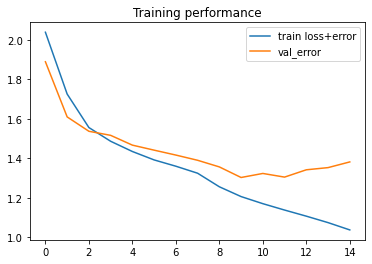

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
test_Y_predictions = model.predict((iq_test, mp_test), batch_size=BATCH_SIZE)

test_Y_predictions_length = len(test_Y_predictions)
test_Y_onehotted = []

for i in range(0, test_Y_predictions_length - 1):
    # creating a [0...0] vector
    onehotted_prediction = np.zeros(len(classes))
    
    # I have to place a 1 where the probability value is maximum
    onehot_one_index = np.argmax(test_Y_predictions[i])
    onehotted_prediction[onehot_one_index] = 1
    
    test_Y_onehotted.append(onehotted_prediction)

In [21]:
# 11x11 zeros matrix
confusion_matrix = np.zeros((len(classes), len(classes)))

# row = true label, column = predicted label

for i in range(0, test_Y_predictions_length - 1):
    true_label_index = np.argmax(Y_test[i])
    predicted_label_index = np.argmax(test_Y_onehotted[i])
    
    confusion_matrix[true_label_index][predicted_label_index] += 1

softmaxed_confusion_matrix = np.zeros((len(classes), len(classes)))
    
# softmax each confusion matrix row
for i in range(0, len(classes)):
    vector_sum = np.sum(confusion_matrix[i])
    
    for j in range(0, len(confusion_matrix[i]) - 1):
        softmaxed_confusion_matrix[i][j] += round(confusion_matrix[i][j]/vector_sum, 2)
    
softmaxed_confusion_matrix

array([[0.3 , 0.01, 0.28, 0.01, 0.03, 0.02, 0.02, 0.07, 0.04, 0.2 , 0.  ],
       [0.  , 0.67, 0.2 , 0.  , 0.01, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.03, 0.84, 0.01, 0.01, 0.02, 0.02, 0.01, 0.  , 0.02, 0.  ],
       [0.01, 0.01, 0.28, 0.54, 0.01, 0.01, 0.07, 0.01, 0.01, 0.02, 0.  ],
       [0.01, 0.01, 0.28, 0.01, 0.58, 0.03, 0.01, 0.01, 0.01, 0.03, 0.  ],
       [0.  , 0.03, 0.26, 0.01, 0.02, 0.61, 0.01, 0.01, 0.  , 0.01, 0.  ],
       [0.01, 0.01, 0.21, 0.06, 0.01, 0.01, 0.66, 0.01, 0.01, 0.01, 0.  ],
       [0.08, 0.01, 0.18, 0.01, 0.02, 0.01, 0.02, 0.29, 0.31, 0.06, 0.  ],
       [0.07, 0.01, 0.11, 0.01, 0.02, 0.01, 0.01, 0.29, 0.4 , 0.05, 0.  ],
       [0.17, 0.01, 0.28, 0.01, 0.03, 0.02, 0.02, 0.05, 0.03, 0.37, 0.  ],
       [0.  , 0.44, 0.21, 0.  , 0.01, 0.04, 0.01, 0.  , 0.  , 0.01, 0.  ]])

In [22]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

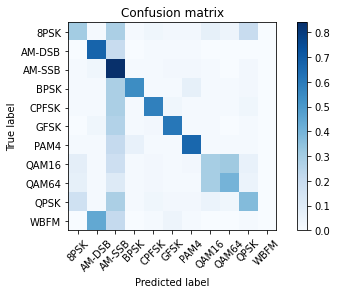

In [23]:
plot_confusion_matrix(softmaxed_confusion_matrix, labels=classes)

## Confusion matrix for each SNR

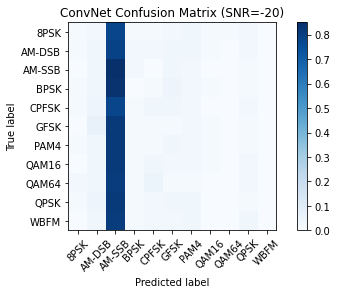

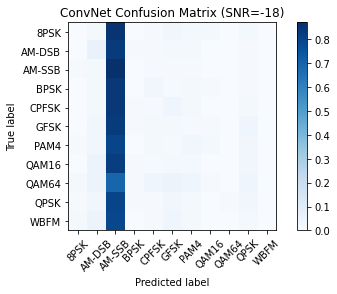

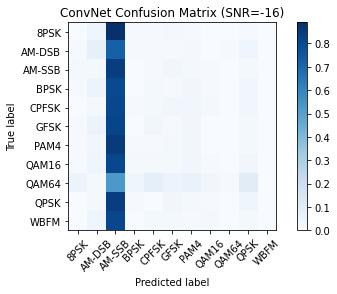

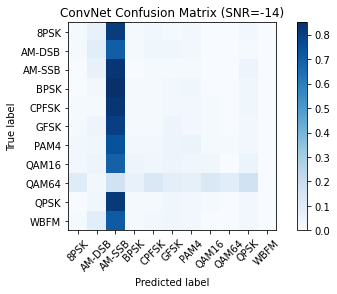

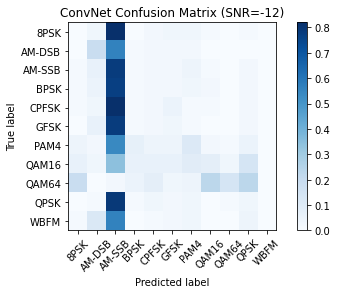

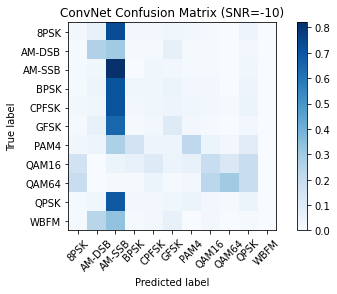

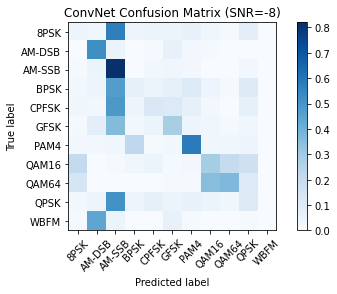

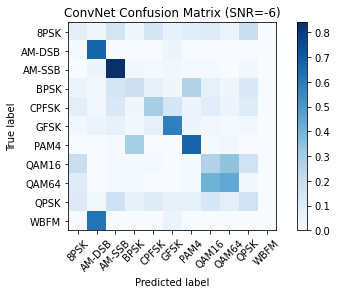

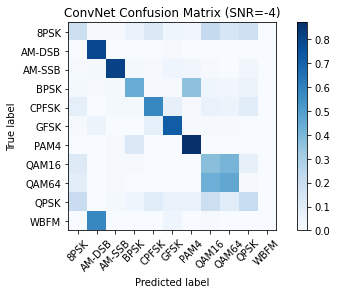

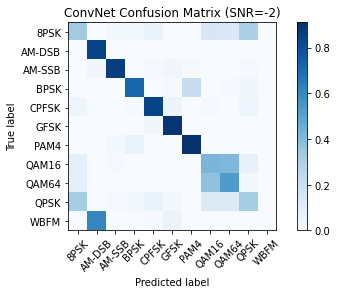

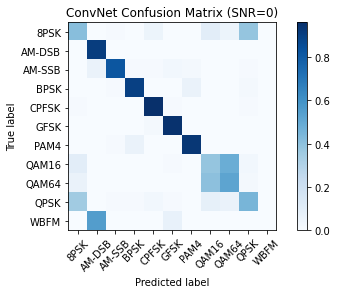

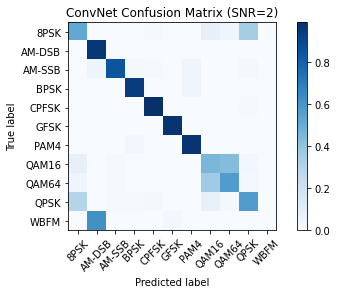

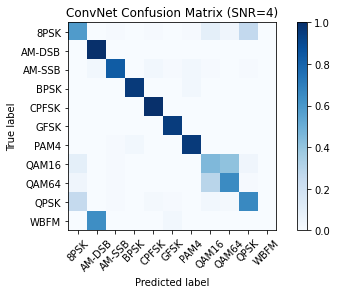

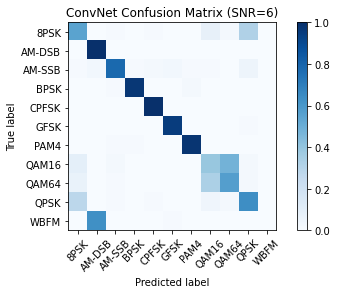

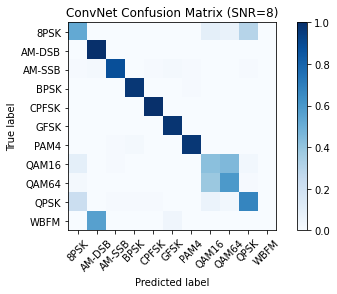

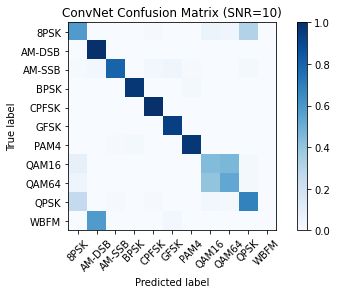

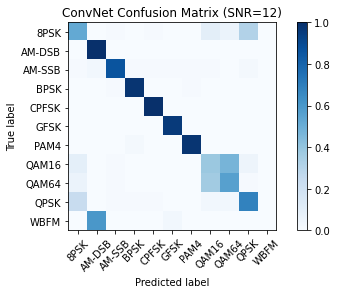

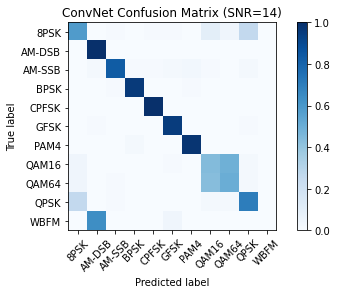

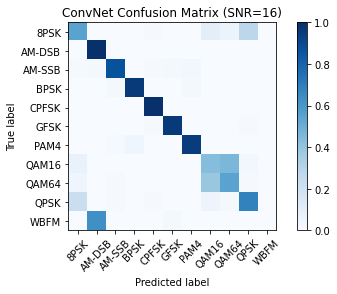

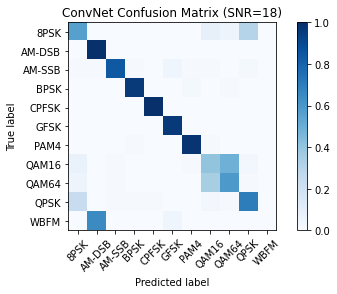

In [24]:
import math

# Plot confusion matrix
acc = {}

for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
        
    test_X_i = (iq_test[this_snr_indexes], mp_test[this_snr_indexes])
    test_Y_i = Y_test[this_snr_indexes]
        
    # estimate classes
    test_Y_predictions = model.predict(test_X_i, batch_size=BATCH_SIZE)
    
    test_Y_predictions_length = len(test_Y_predictions)
    test_Y_onehotted = []
    
    for i in range(0, test_Y_predictions_length - 1):
        # creating a [0...0] vector
        onehotted_prediction = np.zeros(len(classes))

        # I have to place a 1 where the probability value is maximum
        onehot_one_index = np.argmax(test_Y_predictions[i])
        onehotted_prediction[onehot_one_index] = 1

        test_Y_onehotted.append(onehotted_prediction)
            
    # 11x11 zeros matrix
    confusion_matrix = np.zeros((len(classes), len(classes)))

    # row = true label, column = predicted label

    for i in range(0, test_Y_predictions_length - 1):
        true_label_index = np.argmax(test_Y_i[i])
        predicted_label_index = np.argmax(test_Y_onehotted[i])

        confusion_matrix[true_label_index][predicted_label_index] += 1

    softmaxed_confusion_matrix = np.zeros((len(classes), len(classes)))
    
    # softmax each confusion matrix row
    for i in range(0, len(classes)):
        vector_sum = np.sum(confusion_matrix[i])

        for j in range(0, len(confusion_matrix[i]) - 1):
            perc = confusion_matrix[i][j] / vector_sum
            softmaxed_confusion_matrix[i][j] += round(perc, 2)
    
    plt.figure()
    plot_confusion_matrix(softmaxed_confusion_matrix, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    well_predicted = np.sum(np.diag(confusion_matrix))
    all_predictions = np.sum(confusion_matrix)
    
    acc[snr] = well_predicted / all_predictions

## Accuracy performance

In [25]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,10,12,14,20,32,41,52,63,69,74,76,74,76,74,75,74,75,75


In [26]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

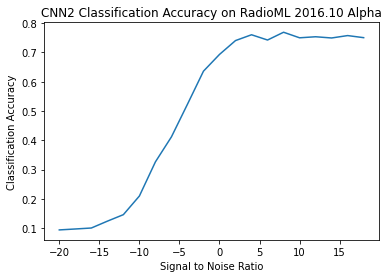

In [27]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")